## SF crime data analysis and modeling

### In this notebook, I performed big data analysis on SF crime data using big data techniques (OLAP). (https://data.sfgov.org/Public-Safety/Police-Department-Incident-Reports-Historical-2003/tmnf-yvry). Unsupervised learning and time series are used to model and analyze the data in time and space.

# By Wanchen Hong
I'm using 18-present data instead, and compare with the past

In [0]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import warnings

import os
os.environ["PYSPARK_PYTHON"] = "python3"


In [0]:
import urllib.request
urllib.request.urlretrieve("https://data.sfgov.org/resource/wg3w-h783.csv?$query=SELECT%0A%20%20%60incident_datetime%60%2C%0A%20%20%60incident_date%60%2C%0A%20%20%60incident_time%60%2C%0A%20%20%60incident_year%60%2C%0A%20%20%60incident_day_of_week%60%2C%0A%20%20%60report_datetime%60%2C%0A%20%20%60row_id%60%2C%0A%20%20%60incident_id%60%2C%0A%20%20%60incident_number%60%2C%0A%20%20%60cad_number%60%2C%0A%20%20%60report_type_code%60%2C%0A%20%20%60report_type_description%60%2C%0A%20%20%60filed_online%60%2C%0A%20%20%60incident_code%60%2C%0A%20%20%60incident_category%60%2C%0A%20%20%60incident_subcategory%60%2C%0A%20%20%60incident_description%60%2C%0A%20%20%60resolution%60%2C%0A%20%20%60intersection%60%2C%0A%20%20%60cnn%60%2C%0A%20%20%60police_district%60%2C%0A%20%20%60analysis_neighborhood%60%2C%0A%20%20%60supervisor_district%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20%60point%60%2C%0A%20%20%60%3A%40computed_region_jwn9_ihcz%60%2C%0A%20%20%60%3A%40computed_region_jg9y_a9du%60%2C%0A%20%20%60%3A%40computed_region_h4ep_8xdi%60%2C%0A%20%20%60%3A%40computed_region_n4xg_c4py%60%2C%0A%20%20%60%3A%40computed_region_nqbw_i6c3%60%2C%0A%20%20%60%3A%40computed_region_viu7_rrfi%60%2C%0A%20%20%60%3A%40computed_region_26cr_cadq%60%2C%0A%20%20%60%3A%40computed_region_qgnn_b9vv%60", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/spark/data/sf_18_present.csv")
urllib.request.urlretrieve("https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD", "/tmp/myxxxx.csv")
dbutils.fs.mv("file:/tmp/myxxxx.csv", "dbfs:/spark/data/sf_03_18.csv")
display(dbutils.fs.ls("dbfs:/spark/data/"))
# https://data.sfgov.org/api/views/tmnf-yvry/rows.csv?accessType=DOWNLOAD


In [0]:
data_path = "dbfs:/spark/data/sf_18_present.csv"
data_path1 = "dbfs:/spark/data/sf_03_18.csv"
# 03-18 data as learning, 18-present data to validate

Can use RDD, Dataframe, register the RDD to a dataframe or SQL to hold the data

In [0]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

df_opt1 = spark.read.format("csv").option("header", "true").load(data_path)
df_opt3 = df_opt1[['incident_number','incident_time', 'incident_year', 'incident_day_of_week', 'incident_datetime', 'incident_category', 'police_district', 'resolution', 'intersection','longitude', 'latitude', 'point']]
display(df_opt3)
df_opt3.createOrReplaceTempView("sf_crime_present")

df_opt2 = spark.read.format("csv").option("header", "true").load(data_path1)
df_opt4 = df_opt2[['IncidntNum', 'Category', 'Descript', 'DayOfWeek', 'Date', 'Time', 'PdDistrict', 'Resolution', 'Address', 'X', 'Y', 'Location']]
display(df_opt4)
df_opt4.createOrReplaceTempView("sf_crime_past")

incident_number incident_time incident_year incident_day_of_week incident_datetime incident_category police_district resolution intersection longitude latitude point 230167874 23:41 2023 Monday 2023-03-13T23:41:00.000 Recovered Vehicle Out of SF Open or Active null null null null 236046151 05:02 2023 Wednesday 2023-03-01T05:02:00.000 Larceny Theft Mission Open or Active null null null null 220343896 13:16 2023 Monday 2023-03-13T13:16:00.000 Recovered Vehicle Out of SF Open or Active null null null null 230174885 10:59 2023 Monday 2023-03-13T10:59:00.000 Recovered Vehicle Out of SF Open or Active null null null null 230176728 18:44 2023 Tuesday 2023-03-14T18:44:00.000 Recovered Vehicle Out of SF Open or Active null null null null 236046123 03:00 2023 Wednesday 2023-02-15T03:00:00.000 Larceny Theft Mission Open or Active null null null null 236046004 12:30 2023 Saturday 2023-03-11T12:30:00.000 Larceny Theft Central Open or Active null null null null 236046850 11:26 2023 Monday 2023-03-13T11:26:00.000 Larceny Theft Central Open or Active null null null null 236045937 15:00 2023 Saturday 2023-03-11T15:00:00.000 Larceny Theft Central Open or Active null null null null 230182844 14:00 2023 Saturday 2023-03-11T14:00:00.000 Assault Park Open or Active STANYAN ST \ HAYES ST -122.45428511766733 37.772895177200766 POINT (-122.45428511766733 37.772895177200766) 236047096 07:30 2023 Monday 2023-03-13T07:30:00.000 Larceny Theft Central Open or Active null null null null 230184129 12:00 2022 Monday 2022-06-27T12:00:00.000 Lost Property Central Open or Active GEARY ST \ POWELL ST -122.40822672700406 37.78735926098589 POINT (-122.40822672700406 37.78735926098589) 230185672 09:26 2023 Thursday 2023-03-16T09:26:00.000 Drug Violation Out of SF Cite or Arrest Adult null null null null 230187101 17:30 2023 Thursday 2023-03-16T17:30:00.000 Assault Bayview Open or Active 18TH ST \ DE HARO ST -122.40132418490647 37.76228996810526 POINT (-122.40132418490647 37.76228996810526) 236047529 14:15 2023 Tuesday 2023-02-21T14:15:00.000 Lost Property Out of SF Open or Active null null null null 230178047 13:49 2023 Thursday 2023-03-16T13:49:00.000 Recovered Vehicle Out of SF Open or Active null null null null 236049456 22:15 2023 Thursday 2023-03-16T22:15:00.000 Larceny Theft Richmond Open or Active null null null null 236046816 11:35 2023 Monday 2023-03-13T11:35:00.000 Larceny Theft Central Open or Active null null null null 236050049 14:00 2023 Saturday 2023-02-11T14:00:00.000 Larceny Theft Central Open or Active null null null null 230172566 21:00 2023 Thursday 2023-03-16T21:00:00.000 Recovered Vehicle Out of SF Open or Active null null null null 236048862 10:00 2023 Wednesday 2023-03-15T10:00:00.000 Malicious Mischief Southern Open or Active null null null null 236049876 20:00 2023 Thursday 2023-03-16T20:00:00.000 Larceny Theft Central Open or Active null null null null 230188660 08:30 2023 Friday 2023-03-17T08:30:00.000 Drug Offense Out of SF Open or Active null null null null 236049951 13:30 2023 Tuesday 2023-03-07T13:30:00.000 Lost Property Central Open or Active null null null null 236048765 12:00 2023 Thursday 2023-03-16T12:00:00.000 Larceny Theft Southern Open or Active null null null null 226100018 16:00 2022 Sunday 2022-05-15T16:00:00.000 Lost Property Out of SF Open or Active null null null null 236050102 14:20 2023 Friday 2023-03-17T14:20:00.000 Larceny Theft Central Open or Active null null null null 230130047 19:15 2023 Saturday 2023-03-18T19:15:00.000 Recovered Vehicle Out of SF Open or Active null null null null 236048420 16:33 2023 Tuesday 2023-03-14T16:33:00.000 Larceny Theft Richmond Open or Active null null null null 230081127 00:43 2023 Saturday 2023-03-18T00:43:00.000 Recovered Vehicle Out of SF Open or Active null null null null 230195483 09:10 2023 Monday 2023-03-20T09:10:00.000 Recovered Vehicle Out of SF Open or Active null null null null 236049490 13:30 2023 Thursday 2023-03-16T13:30:00.000 Larceny Theft Northern Open or Active null

IncidntNum Category Descript DayOfWeek Date Time PdDistrict Resolution Address X Y Location 041334220 ROBBERY ROBBERY, BODILY FORCE Monday 11/22/2004 17:50 INGLESIDE NONE GENEVA AV / SANTOS ST -122.420084075249 37.7083109744362 POINT (-122.420084075249 37.7083109744362) 051185358 VEHICLE THEFT STOLEN AUTOMOBILE Tuesday 10/18/2005 20:00 PARK NONE TURK ST / STJOSEPHS AV -120.5 90 POINT (-120.50000000000001 90) 040188309 VEHICLE THEFT STOLEN AUTOMOBILE Sunday 02/15/2004 02:00 SOUTHERN NONE BRANNAN ST / 1ST ST -120.5 90 POINT (-120.50000000000001 90) 110145431 ARSON ARSON Friday 02/18/2011 05:27 INGLESIDE NONE 0 Block of SANJUAN AV -122.43622001281 37.7243766140428 POINT (-122.43622001281001 37.7243766140428) 101081080 ASSAULT BATTERY Sunday 11/21/2010 17:00 SOUTHERN NONE 400 Block of 10TH ST -122.410541166987 37.7709130566165 POINT (-122.410541166987 37.7709130566165) 130270698 ASSAULT BATTERY Tuesday 04/02/2013 15:50 TARAVAL NONE 14TH AV / SANTIAGO ST -122.470365997562 37.74515794927 POINT (-122.470365997562 37.74515794927) 170639913 ASSAULT BATTERY Sunday 08/06/2017 18:15 SOUTHERN NONE 800 Block of BRYANT ST -122.40340479147905 37.775420706711 POINT (-122.40340479147905 37.775420706711) 160204156 VEHICLE THEFT STOLEN AND RECOVERED VEHICLE Thursday 03/03/2016 19:30 TARAVAL NONE 100 Block of BEPLER ST -122.46354501681947 37.70796836450968 POINT (-122.46354501681947 37.70796836450968) 060685799 ASSAULT BATTERY Saturday 06/17/2006 03:00 TARAVAL NONE 3200 Block of SAN JOSE AV -122.459172646607 37.7082001648459 POINT (-122.459172646607 37.7082001648459) 051341663 TRESPASS TRESPASSING Monday 11/28/2005 16:04 TENDERLOIN ARREST, BOOKED ELLIS ST / 5THSTNORTH ST -120.5 90 POINT (-120.50000000000001 90) 090988438 BURGLARY BURGLARY OF RESIDENCE, FORCIBLE ENTRY Thursday 09/24/2009 13:30 BAYVIEW NONE 1500 Block of SHAFTER AV -122.389849114797 37.7304741509374 POINT (-122.38984911479702 37.7304741509374) 126202675 LARCENY/THEFT GRAND THEFT FROM LOCKED AUTO Friday 12/21/2012 19:15 CENTRAL NONE PACIFIC AV / GRANT AV -122.406831986427 37.7969028838908 POINT (-122.40683198642701 37.7969028838908) 041138389 WARRANTS ENROUTE TO DEPARTMENT OF CORRECTIONS Tuesday 10/05/2004 10:18 TENDERLOIN ARREST, BOOKED ELLIS ST / JONES ST -122.412784096509 37.7848656939297 POINT (-122.412784096509 37.7848656939297) 100145388 OTHER OFFENSES DRIVERS LICENSE, SUSPENDED OR REVOKED Saturday 02/13/2010 02:55 BAYVIEW ARREST, CITED POWELL ST / VALLEJO ST -122.41045954645 37.7983714449989 POINT (-122.41045954645001 37.7983714449989) 100033125 OTHER OFFENSES DRIVERS LICENSE, SUSPENDED OR REVOKED Monday 01/11/2010 03:38 SOUTHERN ARREST, BOOKED 6TH ST / MISSION ST -122.408710606663 37.7809706722053 POINT (-122.408710606663 37.7809706722053) 120714349 TRESPASS TRESPASSING Friday 08/17/2012 20:30 NORTHERN NONE 1900 Block of PACIFIC AV -122.427363308517 37.7943446897793 POINT (-122.427363308517 37.7943446897793) 100180889 LARCENY/THEFT PETTY THEFT SHOPLIFTING Tuesday 02/23/2010 17:57 SOUTHERN ARREST, CITED 800 Block of MARKET ST -122.406520987144 37.7850629421661 POINT (-122.40652098714399 37.7850629421661) 040829218 ROBBERY ROBBERY OF A COMMERCIAL ESTABLISHMENT WITH A GUN Wednesday 07/21/2004 07:30 TENDERLOIN NONE 200 Block of LEAVENWORTH ST -122.414081138014 37.7832767266062 POINT (-122.41408113801401 37.7832767266062) 030716039 DRUG/NARCOTIC POSSESSION OF HEROIN Thursday 06/12/2003 20:25 INGLESIDE ARREST, BOOKED BANNOCK ST / SENECA AV -122.441875049315 37.7190816366737 POINT (-122.44187504931502 37.7190816366737) 126018074 LARCENY/THEFT GRAND THEFT OF PROPERTY Monday 02/06/2012 18:00 MISSION NONE MARKET ST / SANCHEZ ST -122.431028702713 37.7658672394532 POINT (-122.43102870271298 37.7658672394532) 060388705 SUSPICIOUS OCC SUSPICIOUS OCCURRENCE Tuesday 04/11/2006 16:00 SOUTHERN NONE 200 Block of 6TH ST -122.406346425632 37.7791674218963 POINT (-122.40634642563201 37.7791674218963) 040725741 LARCENY/THEFT GRAND THEFT PICKPOCKET Saturday 05/22/2004 15:00 NORTHERN NONE HAIGHT ST /

## Data Exploration

The number of crimes in each different category:

In [0]:
# Present data is 2018 onward, past data is 2003-2018
cat_result1 = df_opt3.groupBy('incident_category').count().orderBy('count', ascending=False)
display(cat_result1) # the present dataset
cat_result2 = df_opt4.groupBy('Category').count().orderBy('count', ascending=False)
display(cat_result2) # the past dataset

incident_category count Larceny Theft 411 Recovered Vehicle 196 Lost Property 118 Malicious Mischief 54 Non-Criminal 51 Assault 35 Other Miscellaneous 19 Fraud 16 Other Offenses 15 Warrant 12 Robbery 10 Burglary 10 Missing Person 9 Drug Offense 8 Motor Vehicle Theft 7 Arson 6 Other 4 Weapons Carrying Etc 4 Suspicious Occ 3 Disorderly Conduct 2 Vandalism 2 Fire Report 1 Drug Violation 1 Rape 1 Suicide 1 Traffic Collision 1 Case Closure 1 Offences Against The Family And Children 1 Stolen Property 1

Category count LARCENY/THEFT 477975 OTHER OFFENSES 301874 NON-CRIMINAL 236928 ASSAULT 167042 VEHICLE THEFT 126228 DRUG/NARCOTIC 117821 VANDALISM 114718 WARRANTS 99821 BURGLARY 91067 SUSPICIOUS OCC 79087 ROBBERY 54467 MISSING PERSON 44268 FRAUD 41348 FORGERY/COUNTERFEITING 22995 SECONDARY CODES 22378 WEAPON LAWS 21004 TRESPASS 19194 PROSTITUTION 16501 STOLEN PROPERTY 11450 DISORDERLY CONDUCT 9932 DRUNKENNESS 9760 SEX OFFENSES, FORCIBLE 8747 RECOVERED VEHICLE 8688 DRIVING UNDER THE INFLUENCE 5652 KIDNAPPING 4282 ARSON 3875 EMBEZZLEMENT 2984 LIQUOR LAWS 2840 LOITERING 2402 SUICIDE 1291 BAD CHECKS 924 BRIBERY 796 EXTORTION 729 GAMBLING 343 PORNOGRAPHY/OBSCENE MAT 57 SEX OFFENSES, NON FORCIBLE 43 TREA 14

In [0]:
#Spark SQL based
cat_sql1 = spark.sql("SELECT  incident_category, COUNT(*) AS Count FROM sf_crime_present GROUP BY incident_category ORDER BY Count DESC")
display(cat_sql1) # present dataset
cat_sql2 = spark.sql("SELECT  Category, COUNT(*) AS Count FROM sf_crime_past GROUP BY Category ORDER BY Count DESC")
display(cat_sql2) # past dataset

incident_category Count Larceny Theft 411 Recovered Vehicle 196 Lost Property 118 Malicious Mischief 54 Non-Criminal 51 Assault 35 Other Miscellaneous 19 Fraud 16 Other Offenses 15 Warrant 12 Robbery 10 Burglary 10 Missing Person 9 Drug Offense 8 Motor Vehicle Theft 7 Arson 6 Other 4 Weapons Carrying Etc 4 Suspicious Occ 3 Disorderly Conduct 2 Vandalism 2 Fire Report 1 Drug Violation 1 Rape 1 Suicide 1 Traffic Collision 1 Case Closure 1 Offences Against The Family And Children 1 Stolen Property 1

Category Count LARCENY/THEFT 477975 OTHER OFFENSES 301874 NON-CRIMINAL 236928 ASSAULT 167042 VEHICLE THEFT 126228 DRUG/NARCOTIC 117821 VANDALISM 114718 WARRANTS 99821 BURGLARY 91067 SUSPICIOUS OCC 79087 ROBBERY 54467 MISSING PERSON 44268 FRAUD 41348 FORGERY/COUNTERFEITING 22995 SECONDARY CODES 22378 WEAPON LAWS 21004 TRESPASS 19194 PROSTITUTION 16501 STOLEN PROPERTY 11450 DISORDERLY CONDUCT 9932 DRUNKENNESS 9760 SEX OFFENSES, FORCIBLE 8747 RECOVERED VEHICLE 8688 DRIVING UNDER THE INFLUENCE 5652 KIDNAPPING 4282 ARSON 3875 EMBEZZLEMENT 2984 LIQUOR LAWS 2840 LOITERING 2402 SUICIDE 1291 BAD CHECKS 924 BRIBERY 796 EXTORTION 729 GAMBLING 343 PORNOGRAPHY/OBSCENE MAT 57 SEX OFFENSES, NON FORCIBLE 43 TREA 14

In [0]:
## first step: spark df or sql to compute the statisitc result 
## second step: export your result to a pandas dataframe and plot using matplotlib. 

crimes_pd_df1 = cat_sql1.toPandas()
display(crimes_pd_df1) #present
crimes_pd_df2 = cat_sql2.toPandas()
display(crimes_pd_df2) #past


incident_category Count Larceny Theft 411 Recovered Vehicle 196 Lost Property 118 Malicious Mischief 54 Non-Criminal 51 Assault 35 Other Miscellaneous 19 Fraud 16 Other Offenses 15 Warrant 12 Robbery 10 Burglary 10 Missing Person 9 Drug Offense 8 Motor Vehicle Theft 7 Arson 6 Other 4 Weapons Carrying Etc 4 Suspicious Occ 3 Disorderly Conduct 2 Vandalism 2 Fire Report 1 Drug Violation 1 Rape 1 Suicide 1 Traffic Collision 1 Case Closure 1 Offences Against The Family And Children 1 Stolen Property 1

Category Count LARCENY/THEFT 477975 OTHER OFFENSES 301874 NON-CRIMINAL 236928 ASSAULT 167042 VEHICLE THEFT 126228 DRUG/NARCOTIC 117821 VANDALISM 114718 WARRANTS 99821 BURGLARY 91067 SUSPICIOUS OCC 79087 ROBBERY 54467 MISSING PERSON 44268 FRAUD 41348 FORGERY/COUNTERFEITING 22995 SECONDARY CODES 22378 WEAPON LAWS 21004 TRESPASS 19194 PROSTITUTION 16501 STOLEN PROPERTY 11450 DISORDERLY CONDUCT 9932 DRUNKENNESS 9760 SEX OFFENSES, FORCIBLE 8747 RECOVERED VEHICLE 8688 DRIVING UNDER THE INFLUENCE 5652 KIDNAPPING 4282 ARSON 3875 EMBEZZLEMENT 2984 LIQUOR LAWS 2840 LOITERING 2402 SUICIDE 1291 BAD CHECKS 924 BRIBERY 796 EXTORTION 729 GAMBLING 343 PORNOGRAPHY/OBSCENE MAT 57 SEX OFFENSES, NON FORCIBLE 43 TREA 14

<Figure size 432x288 with 0 Axes>

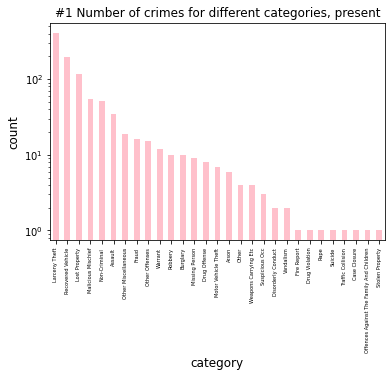

<Figure size 432x288 with 0 Axes>

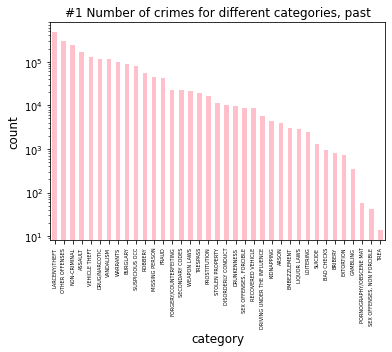

In [0]:
plt.figure()
ax1 = crimes_pd_df1.plot(kind = 'bar',x = 'incident_category',y = 'Count',logy= True,color = 'pink',legend = False, align = 'center')
ax1.set_ylabel('count',fontsize = 12)
ax1.set_xlabel('category',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('#1 Number of crimes for different categories, present')
display()

plt.figure()
ax2 = crimes_pd_df2.plot(kind = 'bar',x = 'Category',y = 'Count',logy= True,color = 'pink',legend = False, align = 'center')
ax2.set_ylabel('count',fontsize = 12)
ax2.set_xlabel('category',fontsize = 12)
plt.xticks(fontsize=5, rotation=90)
plt.title('#1 Number of crimes for different categories, past')
display()

There are much more Larceny/Theft crimes than other types of crimes in both the present and the past, which is reasonable. Also, some categories of crimes, such as vandalism, is less prevalent in the more recent data than the historic data, which could more or less shows a decreasing trend of those kind of crimes. It would be interesting to study how they might vary in time.

What about different districts?

In [0]:
district_sql_1 = spark.sql("SELECT police_district, COUNT(*) AS Count FROM sf_crime_present GROUP BY 1 ORDER BY 2 DESC")
display(district_sql_1) # present
district_sql_2 = spark.sql("SELECT PdDistrict, COUNT(*) AS Count FROM sf_crime_past GROUP BY 1 ORDER BY 2 DESC")
display(district_sql_2) # past

police_district Count Out of SF 352 Central 163 Southern 101 Mission 82 Richmond 79 Northern 59 Park 57 Taraval 43 Bayview 35 Ingleside 20 Tenderloin 9

PdDistrict Count SOUTHERN 390692 MISSION 288985 NORTHERN 266435 CENTRAL 221923 BAYVIEW 205480 TENDERLOIN 186954 INGLESIDE 181092 TARAVAL 155461 PARK 119698 RICHMOND 112804 NA 1

<Figure size 432x288 with 0 Axes>

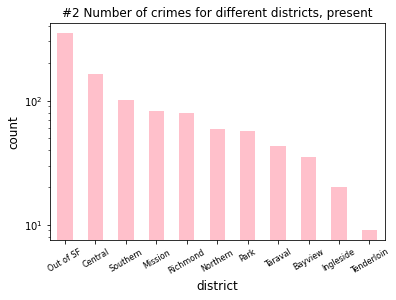

<Figure size 432x288 with 0 Axes>

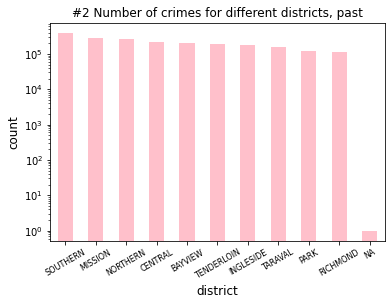

In [0]:
crimes_dis_pd_df = district_sql_1.toPandas()
plt.figure()

ax = crimes_dis_pd_df.plot(kind = 'bar',x='police_district',y = 'Count',logy= True,color = 'pink',legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('district',fontsize = 12)
plt.xticks(fontsize=8, rotation=30)
plt.title('#2 Number of crimes for different districts, present')
display()

crimes_dis_pd_df = district_sql_2.toPandas()
plt.figure()

ax = crimes_dis_pd_df.plot(kind = 'bar',x='PdDistrict',y = 'Count',logy= True,color = 'pink',legend = False, align = 'center')
ax.set_ylabel('count',fontsize = 12)
ax.set_xlabel('district',fontsize = 12)
plt.xticks(fontsize=8, rotation=30)
plt.title('#2 Number of crimes for different districts, past')
display()

Crimes in areas like southern SF looks like decreasing in count, and in areas like central SF may be increasing. It would be interesting to see how that changes in time as well.

From the news, a lot of crimes happen in downtown SF. How does the actual number of crimes in downtown compared to the rest?
I used the latitude and longtitude range for downtown SF: X (-122.4213,-122.4313), Y(37.7540,37.7740)

In [0]:
dt_result1 = spark.sql("""
                      with dt_crime as(
                      select substring(incident_datetime,6,5) as Date,
                             incident_year as Year
                      from sf_crime_present
                      where (-122.433671 < longitude
                             and longitude < -122.402497
                             and 37.753510 < latitude
                             and latitude < 37.782137)
                             )
                             
                      select Year, Date, COUNT(*) as Count
                      from dt_crime
                      group by Year, Date
                      order by Year, Date
                      """)
display(dt_result1) #present, downtown

ndt_result1 = spark.sql("""
                      with ndt_crime as(
                      select substring(incident_datetime,6,5) as Date,
                             incident_year as Year
                      from sf_crime_present
                      where (-122.433671 > longitude
                             or longitude > -122.402497
                             or 37.753510 > latitude
                             or latitude > 37.782137)
                             )
                             
                      select Year, Date, COUNT(*) as Count
                      from ndt_crime
                      group by Year, Date
                      order by Year, Date
                      """)
display(ndt_result1) #present, not downtown

Year Date Count 2019 06-11 1 2021 07-07 1 2021 07-22 1 2021 08-01 1 2021 08-04 1 2021 08-20 1 2021 09-21 1 2021 09-30 1 2021 10-21 1 2021 10-23 1 2021 10-26 1 2021 10-27 1 2021 10-31 1 2021 11-10 1 2022 01-02 1 2022 01-05 1 2022 01-15 1 2022 01-21 1 2022 01-31 1 2022 03-01 1 2022 09-25 1 2022 11-12 1

Year Date Count 2020 11-29 1 2021 06-04 1 2021 06-05 1 2021 06-08 1 2021 06-24 1 2021 07-01 1 2021 07-03 1 2021 07-07 1 2021 07-08 1 2021 07-09 1 2021 07-12 2 2021 07-14 1 2021 07-17 1 2021 07-18 2 2021 07-20 2 2021 07-22 1 2021 07-26 1 2021 07-31 2 2021 08-03 1 2021 08-16 1 2021 08-22 1 2021 08-29 1 2021 08-30 1 2021 09-03 1 2021 09-06 1 2021 09-12 1 2021 09-14 1 2021 09-16 1 2021 09-20 1 2021 09-21 1 2021 09-22 1 2021 09-24 1 2021 09-27 1 2021 09-29 1 2021 10-10 1 2021 10-13 2 2021 10-14 2 2021 10-17 1 2021 10-18 1 2021 10-21 3 2021 10-24 1 2021 10-27 1 2021 10-29 1 2021 10-30 1 2021 11-01 1 2021 11-04 1 2021 11-10 1 2021 11-12 1 2021 11-15 1 2021 11-17 1 2021 11-19 1 2021 11-22 1 2021 11-28 1 2021 11-29 1 2021 12-01 1 2021 12-05 1 2021 12-06 1 2021 12-08 1 2021 12-17 1 2021 12-18 2 2021 12-21 1 2021 12-23 1 2021 12-26 1 2022 01-21 2 2022 01-22 1 2022 01-23 1 2022 01-29 1 2022 01-31 1 2022 02-03 1 2022 02-22 1 2022 02-25 1 2022 02-27 1 2022 02-28 1 2022 03-04 3 2022 03-06 1 2022 03-16 1 2022 03-21 1 2022 04-01 1 2022 05-07 1 2022 05-09 1 2022 05-10 1 2022 05-13 1 2022 06-11 1 2022 06-27 1 2022 07-01 1 2022 07-02 1 2022 07-04 1 2022 11-12 1 2023 03-11 1 2023 03-16 1 2023 03-21 1

In [0]:
dt_result2 = spark.sql("""
                      with dt_crime as(
                      select substring(Date,1,5) as Date,
                             substring(Date,7) as Year
                      from sf_crime_past
                      where (-122.423671 < X
                             and X < 122.412497
                             and 37.773510 < Y
                             and Y < 37.782137)
                             )
                             
                      select Year, Date, COUNT(*) as Count
                      from dt_crime
                      group by Year, Date
                      order by Year, Date
                      """)
display(dt_result2) #past, downtown

ndt_result2 = spark.sql("""
                      with ndt_crime as(
                      select substring(Date,1,5) as Date,
                             substring(Date,7) as Year
                      from sf_crime_past
                      where (-122.423671 > X
                             or X > 122.412497
                             or 37.773510 > Y
                             or Y > 37.782137)
                             )
                             
                      select Year, Date, COUNT(*) as Count
                      from ndt_crime
                      group by Year, Date
                      order by Year, Date
                      """)
display(ndt_result2) #past, not downtown

Year Date Count 2003 01/01 79 2003 01/02 43 2003 01/03 60 2003 01/04 33 2003 01/05 28 2003 01/06 41 2003 01/07 55 2003 01/08 69 2003 01/09 63 2003 01/10 44 2003 01/11 39 2003 01/12 33 2003 01/13 56 2003 01/14 43 2003 01/15 40 2003 01/16 47 2003 01/17 46 2003 01/18 42 2003 01/19 19 2003 01/20 66 2003 01/21 53 2003 01/22 56 2003 01/23 37 2003 01/24 54 2003 01/25 59 2003 01/26 32 2003 01/27 67 2003 01/28 47 2003 01/29 84 2003 01/30 57 2003 01/31 47 2003 02/01 42 2003 02/02 44 2003 02/03 37 2003 02/04 61 2003 02/05 46 2003 02/06 54 2003 02/07 60 2003 02/08 52 2003 02/09 46 2003 02/10 55 2003 02/11 41 2003 02/12 42 2003 02/13 52 2003 02/14 52 2003 02/15 57 2003 02/16 50 2003 02/17 43 2003 02/18 61 2003 02/19 54 2003 02/20 59 2003 02/21 41 2003 02/22 40 2003 02/23 48 2003 02/24 57 2003 02/25 57 2003 02/26 63 2003 02/27 48 2003 02/28 49 2003 03/01 41 2003 03/02 40 2003 03/03 48 2003 03/04 60 2003 03/05 52 2003 03/06 47 2003 03/07 48 2003 03/08 58 2003 03/09 49 2003 03/10 69 2003 03/11 57 2003 03/12 55 2003 03/13 49 2003 03/14 51 2003 03/15 35 2003 03/16 43 2003 03/17 51 2003 03/18 51 2003 03/19 36 2003 03/20 56 2003 03/21 50 2003 03/22 48 2003 03/23 32 2003 03/24 36 2003 03/25 36 2003 03/26 37 2003 03/27 57 2003 03/28 55 2003 03/29 60 2003 03/30 45 2003 03/31 51 2003 04/01 89 2003 04/02 60 2003 04/03 72 2003 04/04 71 2003 04/05 61 2003 04/06 41 2003 04/07 50 2003 04/08 62 2003 04/09 80 2003 04/10 75 2003 04/11 72 2003 04/12 27 2003 04/13 44 2003 04/14 54 2003 04/15 59 2003 04/16 57 2003 04/17 60 2003 04/18 58 2003 04/19 35 2003 04/20 42 2003 04/21 41 2003 04/22 75 2003 04/23 68 2003 04/24 53 2003 04/25 53 2003 04/26 51 2003 04/27 43 2003 04/28 50 2003 04/29 66 2003 04/30 49 2003 05/01 57 2003 05/02 54 2003 05/03 41 2003 05/04 33 2003 05/05 48 2003 05/06 68 2003 05/07 62 2003 05/08 55 2003 05/09 52 2003 05/10 40 2003 05/11 30 2003 05/12 48 2003 05/13 56 2003 05/14 62 2003 05/15 56 2003 05/16 51 2003 05/17 40 2003 05/18 49 2003 05/19 44 2003 05/20 46 2003 05/21 50 2003 05/22 44 2003 05/23 31 2003 05/24 35 2003 05/25 39 2003 05/26 49 2003 05/27 52 2003 05/28 45 2003 05/29 40 2003 05/30 44 2003 05/31 58 2003 06/01 75 2003 06/02 58 2003 06/03 39 2003 06/04 70 2003 06/05 63 2003 06/06 53 2003 06/07 27 2003 06/08 37 2003 06/09 43 2003 06/10 52 2003 06/11 60 2003 06/12 46 2003 06/13 64 2003 06/14 29 2003 06/15 41 2003 06/16 42 2003 06/17 46 2003 06/18 59 2003 06/19 64 2003 06/20 58 2003 06/21 44 2003 06/22 38 2003 06/23 83 2003 06/24 57 2003 06/25 76 2003 06/26 63 2003 06/27 46 2003 06/28 51 2003 06/29 65 2003 06/30 45 2003 07/01 66 2003 07/02 63 2003 07/03 68 2003 07/04 58 2003 07/05 44 2003 07/06 36 2003 07/07 34 2003 07/08 60 2003 07/09 54 2003 07/10 49 2003 07/11 50 2003 07/12 45 2003 07/13 47 2003 07/14 39 2003 07/15 48 2003 07/16 54 2003 07/17 71 2003 07/18 64 2003 07/19 48 2003 07/20 48 2003 07/21 47 2003 07/22 56 2003 07/23 50 2003 07/24 53 2003 07/25 51 2003 07/26 52 2003 07/27 34 2003 07/28 31 2003 07/29 37 2003 07/30 46 2003 07/31 45 2003 08/01 65 2003 08/02 39 2003 08/03 39 2003 08/04 40 2003 08/05 46 2003 08/06 47 2003 08/07 74 2003 08/08 51 2003 08/09 48 2003 08/10 42 2003 08/11 35 2003 08/12 41 2003 08/13 46 2003 08/14 59 2003 08/15 54 2003 08/16 38 2003 08/17 26 2003 08/18 37 2003 08/19 63 2003 08/20 48 2003 08/21 65 2003 08/22 57 2003 08/23 57 2003 08/24 40 2003 08/25 53 2003 08/26 48 2003 08/27 54 2003 08/28 52 2003 08/29 42 2003 08/30 43 2003 08/31 38 2003 09/01 53 2003 09/02 53 2003 09/03 54 2003 09/04 41 2003 09/05 59 2003 09/06 55 2003 09/07 41 2003 09/08 41 2003 09/09 57 2003 09/10 59 2003 09/11 54 2003 09/12 47 2003 09/13 52 2003 09/14 38 2003 09/15 53 2003 09/16 55 2003 09/17 45 2003 09/18 43 2003 09/19 45 2003 09/20 48 2003 09/21 44 2003 09/22 48 2003 09/23 50 2003 09/24 70 2003 09/25 45 2003 09/26 62 2003 09/27 58 2003 09/28 39 2003 09/29 69 2003 09/30 60 2003 10/01 81 2003 10/02 59 2003 10/03 56 2003 10/04 34 2003 10/05 37 2003 10/06 50 2003 10/07 52 2003 10/08 62 2003 10/09 36 2003 10/10 36 2003 10/11 41 2003 10/

Year Date Count 2003 01/01 503 2003 01/02 341 2003 01/03 358 2003 01/04 295 2003 01/05 339 2003 01/06 348 2003 01/07 344 2003 01/08 443 2003 01/09 339 2003 01/10 333 2003 01/11 312 2003 01/12 275 2003 01/13 322 2003 01/14 344 2003 01/15 357 2003 01/16 338 2003 01/17 373 2003 01/18 303 2003 01/19 272 2003 01/20 333 2003 01/21 307 2003 01/22 384 2003 01/23 397 2003 01/24 382 2003 01/25 393 2003 01/26 285 2003 01/27 336 2003 01/28 373 2003 01/29 403 2003 01/30 345 2003 01/31 350 2003 02/01 367 2003 02/02 303 2003 02/03 357 2003 02/04 374 2003 02/05 345 2003 02/06 409 2003 02/07 418 2003 02/08 302 2003 02/09 302 2003 02/10 437 2003 02/11 370 2003 02/12 354 2003 02/13 364 2003 02/14 360 2003 02/15 291 2003 02/16 265 2003 02/17 323 2003 02/18 408 2003 02/19 385 2003 02/20 351 2003 02/21 353 2003 02/22 378 2003 02/23 304 2003 02/24 330 2003 02/25 363 2003 02/26 409 2003 02/27 370 2003 02/28 374 2003 03/01 407 2003 03/02 305 2003 03/03 329 2003 03/04 390 2003 03/05 348 2003 03/06 354 2003 03/07 419 2003 03/08 341 2003 03/09 301 2003 03/10 329 2003 03/11 382 2003 03/12 442 2003 03/13 365 2003 03/14 424 2003 03/15 360 2003 03/16 306 2003 03/17 340 2003 03/18 354 2003 03/19 289 2003 03/20 382 2003 03/21 333 2003 03/22 311 2003 03/23 279 2003 03/24 325 2003 03/25 350 2003 03/26 378 2003 03/27 384 2003 03/28 371 2003 03/29 354 2003 03/30 334 2003 03/31 311 2003 04/01 416 2003 04/02 359 2003 04/03 345 2003 04/04 397 2003 04/05 338 2003 04/06 290 2003 04/07 276 2003 04/08 373 2003 04/09 384 2003 04/10 384 2003 04/11 441 2003 04/12 321 2003 04/13 332 2003 04/14 386 2003 04/15 386 2003 04/16 304 2003 04/17 334 2003 04/18 360 2003 04/19 319 2003 04/20 314 2003 04/21 315 2003 04/22 336 2003 04/23 421 2003 04/24 348 2003 04/25 361 2003 04/26 398 2003 04/27 274 2003 04/28 335 2003 04/29 339 2003 04/30 347 2003 05/01 419 2003 05/02 372 2003 05/03 284 2003 05/04 297 2003 05/05 338 2003 05/06 346 2003 05/07 330 2003 05/08 378 2003 05/09 360 2003 05/10 319 2003 05/11 289 2003 05/12 376 2003 05/13 391 2003 05/14 391 2003 05/15 372 2003 05/16 376 2003 05/17 281 2003 05/18 317 2003 05/19 327 2003 05/20 341 2003 05/21 325 2003 05/22 356 2003 05/23 360 2003 05/24 329 2003 05/25 267 2003 05/26 287 2003 05/27 380 2003 05/28 311 2003 05/29 385 2003 05/30 335 2003 05/31 323 2003 06/01 355 2003 06/02 369 2003 06/03 346 2003 06/04 353 2003 06/05 336 2003 06/06 344 2003 06/07 300 2003 06/08 325 2003 06/09 347 2003 06/10 395 2003 06/11 303 2003 06/12 371 2003 06/13 358 2003 06/14 307 2003 06/15 263 2003 06/16 327 2003 06/17 319 2003 06/18 321 2003 06/19 318 2003 06/20 377 2003 06/21 319 2003 06/22 241 2003 06/23 303 2003 06/24 337 2003 06/25 341 2003 06/26 374 2003 06/27 325 2003 06/28 314 2003 06/29 258 2003 06/30 311 2003 07/01 438 2003 07/02 338 2003 07/03 391 2003 07/04 297 2003 07/05 281 2003 07/06 301 2003 07/07 340 2003 07/08 330 2003 07/09 332 2003 07/10 330 2003 07/11 386 2003 07/12 282 2003 07/13 292 2003 07/14 310 2003 07/15 380 2003 07/16 406 2003 07/17 352 2003 07/18 343 2003 07/19 414 2003 07/20 311 2003 07/21 362 2003 07/22 321 2003 07/23 360 2003 07/24 329 2003 07/25 362 2003 07/26 293 2003 07/27 276 2003 07/28 330 2003 07/29 324 2003 07/30 263 2003 07/31 267 2003 08/01 394 2003 08/02 336 2003 08/03 311 2003 08/04 331 2003 08/05 328 2003 08/06 353 2003 08/07 372 2003 08/08 321 2003 08/09 329 2003 08/10 329 2003 08/11 366 2003 08/12 363 2003 08/13 393 2003 08/14 373 2003 08/15 400 2003 08/16 328 2003 08/17 287 2003 08/18 324 2003 08/19 346 2003 08/20 392 2003 08/21 379 2003 08/22 401 2003 08/23 329 2003 08/24 324 2003 08/25 324 2003 08/26 354 2003 08/27 381 2003 08/28 395 2003 08/29 341 2003 08/30 375 2003 08/31 324 2003 09/01 354 2003 09/02 323 2003 09/03 307 2003 09/04 312 2003 09/05 390 2003 09/06 351 2003 09/07 326 2003 09/08 329 2003 09/09 363 2003 09/10 375 2003 09/11 421 2003 09/12 384 2003 09/13 352 2003 09/14 313 2003 09/15 350 2003 09/16 367 2003 09/17 355 2003 09/18 402 2003 09/19 387 2003 09/20 348 2003 09/21 325 2003 09/22 379 2003 09/2

It appears that the news may give a false impression. For the past data, the number of crimes downtown is approximately the same as the number of crimes not downtown, while for the more recent data, there are way more crimes not downtown than downtow.

Now I would like to see how the number of crimes vary by month, for the recent data, to see if it has been improving recently.

In [0]:
crime_by_month_1 = spark.sql("""
                       SELECT substring(incident_datetime,6,2) as Month,
                             incident_year as Year, COUNT(*) AS Count
                       FROM sf_crime_present
                       GROUP BY Year, Month
                       HAVING Year in (2018,2019,2020,2021,2022,2023) 
                       ORDER BY Year, Month
                       """)
display(crime_by_month_1) #present

Month Year Count 01 2018 9 02 2018 6 03 2018 7 04 2018 6 05 2018 10 06 2018 10 07 2018 9 08 2018 8 09 2018 5 10 2018 3 11 2018 1 12 2018 2 01 2019 6 02 2019 4 03 2019 2 04 2019 2 05 2019 2 06 2019 5 07 2019 4 08 2019 8 09 2019 1 10 2019 5 11 2019 4 12 2019 1 01 2020 5 02 2020 3 03 2020 1 04 2020 2 05 2020 1 06 2020 3 07 2020 3 08 2020 2 09 2020 1 11 2020 2 12 2020 1 01 2021 8 02 2021 8 03 2021 6 04 2021 12 05 2021 7 06 2021 50 07 2021 72 08 2021 46 09 2021 69 10 2021 98 11 2021 95 12 2021 95 01 2022 71 02 2022 41 03 2022 48 04 2022 18 05 2022 27 06 2022 20 07 2022 9 08 2022 3 09 2022 6 10 2022 1 11 2022 7 12 2022 3 01 2023 2 02 2023 4 03 2023 30

Databricks visualization. Run in Databricks to view.

The recent data here does not seem to be complete, give that the number of crimes in 2018-2020 is so low compared to 2021 and 2022. Therefore, I would like to check the count from 2015 to 2018 in the past data as a comparison.

In [0]:
crime_by_month_2 = spark.sql("""
                      with Monthly_crime as(
                      select Date,
                             substring(Date,7) as Year,
                             substring(Date,1,2) as Month
                      from sf_crime_past
                      )
                      
                      select Year, Month, COUNT(*) as Count
                      from Monthly_crime
                      group by Year, Month
                      order by Year, Month
                      """)
display(crime_by_month_2) #past

Year Month Count 2003 01 12366 2003 02 11377 2003 03 12400 2003 04 12251 2003 05 12041 2003 06 11451 2003 07 11889 2003 08 12390 2003 09 12213 2003 10 12475 2003 11 11338 2003 12 10612 2004 01 12473 2004 02 11380 2004 03 12490 2004 04 12190 2004 05 12749 2004 06 11728 2004 07 12118 2004 08 12132 2004 09 11322 2004 10 11663 2004 11 10668 2004 12 11141 2005 01 11887 2005 02 10304 2005 03 11725 2005 04 11567 2005 05 11784 2005 06 11218 2005 07 11491 2005 08 11804 2005 09 11260 2005 10 12269 2005 11 11150 2005 12 10589 2006 01 11349 2006 02 10236 2006 03 11113 2006 04 11062 2006 05 10960 2006 06 11140 2006 07 11259 2006 08 12048 2006 09 10901 2006 10 11280 2006 11 10271 2006 12 10237 2007 01 11062 2007 02 9969 2007 03 11286 2007 04 10524 2007 05 10846 2007 06 10624 2007 07 11437 2007 08 11370 2007 09 11477 2007 10 11632 2007 11 11120 2007 12 10424 2008 01 11397 2008 02 10517 2008 03 11848 2008 04 10894 2008 05 11301 2008 06 10275 2008 07 11875 2008 08 11060 2008 09 11610 2008 10 12376 2008 11 11383 2008 12 10706 2009 01 11466 2009 02 10226 2009 03 12162 2009 04 11608 2009 05 10817 2009 06 9924 2009 07 11043 2009 08 12598 2009 09 11900 2009 10 11503 2009 11 10841 2009 12 10221 2010 01 10805 2010 02 9779 2010 03 10613 2010 04 9995 2010 05 11082 2010 06 10443 2010 07 10521 2010 08 11200 2010 09 11295 2010 10 11382 2010 11 10339 2010 12 10304 2011 01 11058 2011 02 9542 2011 03 10885 2011 04 10636 2011 05 10913 2011 06 10512 2011 07 10294 2011 08 10605 2011 09 10762 2011 10 10899 2011 11 10105 2011 12 10502 2012 01 11109 2012 02 10393 2012 03 10985 2012 04 10788 2012 05 11336 2012 06 10681 2012 07 11160 2012 08 11932 2012 09 11495 2012 10 12692 2012 11 11564 2012 12 11329 2013 01 12311 2013 02 11308 2013 03 12458 2013 04 11988 2013 05 12362 2013 06 11971 2013 07 12659 2013 08 13205 2013 09 13325 2013 10 13387 2013 11 11822 2013 12 10868 2014 01 12373 2014 02 11124 2014 03 12407 2014 04 11908 2014 05 11840 2014 06 11499 2014 07 12281 2014 08 12990 2014 09 12081 2014 10 12896 2014 11 11707 2014 12 11738 2015 01 13181 2015 02 11882 2015 03 13463 2015 04 12526 2015 05 13318 2015 06 12853 2015 07 12949 2015 08 13317 2015 09 12476 2015 10 12697 2015 11 11691 2015 12 11106 2016 01 12532 2016 02 11743 2016 03 11950 2016 04 11905 2016 05 12313 2016 06 11727 2016 07 11832 2016 08 12104 2016 09 12092 2016 10 12913 2016 11 12254 2016 12 12629 2017 01 12687 2017 02 11780 2017 03 13250 2017 04 12452 2017 05 12758 2017 06 12186 2017 07 12717 2017 08 12428 2017 09 12204 2017 10 12970 2017 11 11940 2017 12 12115 2018 01 11667 2018 02 9565 2018 03 10354 2018 04 9954 2018 05 3519

Databricks visualization. Run in Databricks to view.

The trend does not seem to vary much during those years, yet the trend within the years may be slightly similar to each other, which means there is possibly a seasonal trend. There may not be a significant trend here. Then what about times within a day? I selected a regular month and checked how it changes during different years.

In [0]:
# for may 16th
hour_result1 = spark.sql("""
                      select substring(incident_time,1,2) as Hour,
                      count(*) as Count
                      from sf_crime_present
                      where incident_datetime like '%-03-%'
                      group by Hour
                      order by Hour
                      """)
display(hour_result1) #present

Hour Count 00 3 02 1 03 1 04 1 05 2 06 1 07 3 08 4 09 5 10 7 11 9 12 2 13 11 14 7 15 8 16 2 17 4 18 6 19 4 20 2 21 7 22 3 23 1

Databricks visualization. Run in Databricks to view.

In [0]:
hour_result2 = spark.sql("""
                      select substring(Time,1,2) as Hour,
                      count(*) as Count
                      from sf_crime_past
                      where Date like '03/%'
                      group by Hour
                      order by Hour
                      """)
display(hour_result2) #past

Hour Count 00 9550 01 5520 02 4562 03 3238 04 2162 05 1810 06 2835 07 4879 08 7060 09 7665 10 8198 11 8414 12 11299 13 9094 14 9634 15 10225 16 10832 17 11506 18 12067 19 10790 20 9952 21 9248 22 9840 23 9009

Databricks visualization. Run in Databricks to view.

The present dataset shows that there is the least crimes during early morning and late afternoon/evening times, the past dataset suggests early morning times mostly, and perhaps after dinner night time. Both together it suggests that not to travel to to the day time if you want to reduce risk of being evolved in a crime, slightly counterintuitive as we might think it is more dangerous during the night.

Then which crimes happen the most during the night and which crimes happen more during the day? I used the most dangerous 3 districts to check it.

In [0]:
# most dangerous districts
dang_district1 = spark.sql( """
                             SELECT police_district, COUNT(*) as Count
                             FROM sf_crime_present
                             GROUP BY 1
                             ORDER BY 2 DESC
                             LIMIT 3 
                             """ )
display(dang_district1) #present

police_district Count Out of SF 352 Central 163 Southern 101

In [0]:
dang_district2 = spark.sql( """
                             SELECT PdDistrict, COUNT(*) as Count
                             FROM sf_crime_past
                             GROUP BY 1
                             ORDER BY 2 DESC
                             LIMIT 3 
                             """ )
display(dang_district2) #past

PdDistrict Count SOUTHERN 390692 MISSION 288985 NORTHERN 266435

In [0]:
crime_time1 = spark.sql( """
                             SELECT incident_category as category,
                             substring(incident_time,1,2) as Time,
                             count(*) as count
                             FROM sf_crime_present
                             where police_district in (SELECT police_district
                             FROM (SELECT police_district, COUNT(*) as Count
                             FROM sf_crime_present
                             GROUP BY 1
                             ORDER BY 2 DESC
                             LIMIT 3)
                             ) and incident_category is not null
                             GROUP BY category, Time
                             ORDER BY category, Time
                             
                             
                             """ )
display(crime_time1) #present

category Time count Arson 20 1 Arson 21 1 Assault 10 1 Assault 11 1 Assault 12 1 Assault 14 1 Assault 15 1 Assault 18 2 Assault 19 1 Assault 21 2 Assault 23 1 Burglary 10 1 Burglary 11 1 Burglary 15 1 Burglary 19 1 Case Closure 08 1 Disorderly Conduct 15 1 Drug Offense 06 1 Drug Offense 07 1 Drug Offense 08 1 Drug Offense 13 1 Drug Offense 14 1 Drug Offense 15 1 Drug Offense 16 2 Drug Violation 09 1 Fraud 00 3 Fraud 03 1 Fraud 07 1 Fraud 09 1 Fraud 10 1 Fraud 11 1 Fraud 13 1 Fraud 21 1 Larceny Theft 00 7 Larceny Theft 01 5 Larceny Theft 02 2 Larceny Theft 03 1 Larceny Theft 04 1 Larceny Theft 05 2 Larceny Theft 06 1 Larceny Theft 07 1 Larceny Theft 08 3 Larceny Theft 09 2 Larceny Theft 10 9 Larceny Theft 11 15 Larceny Theft 12 13 Larceny Theft 13 10 Larceny Theft 14 2 Larceny Theft 15 9 Larceny Theft 16 10 Larceny Theft 17 20 Larceny Theft 18 18 Larceny Theft 19 18 Larceny Theft 20 13 Larceny Theft 21 14 Larceny Theft 22 4 Larceny Theft 23 6 Lost Property 00 2 Lost Property 01 1 Lost Property 02 2 Lost Property 05 1 Lost Property 06 1 Lost Property 07 1 Lost Property 08 5 Lost Property 09 5 Lost Property 10 3 Lost Property 11 5 Lost Property 12 4 Lost Property 13 4 Lost Property 14 7 Lost Property 15 5 Lost Property 16 4 Lost Property 17 4 Lost Property 18 7 Lost Property 19 9 Lost Property 20 5 Lost Property 21 2 Lost Property 22 3 Lost Property 23 1 Malicious Mischief 00 2 Malicious Mischief 03 1 Malicious Mischief 05 1 Malicious Mischief 08 2 Malicious Mischief 09 1 Malicious Mischief 10 1 Malicious Mischief 11 1 Malicious Mischief 12 2 Malicious Mischief 13 1 Malicious Mischief 14 3 Malicious Mischief 15 1 Malicious Mischief 16 1 Malicious Mischief 17 1 Malicious Mischief 18 1 Malicious Mischief 19 6 Malicious Mischief 20 3 Malicious Mischief 23 2 Missing Person 00 2 Missing Person 02 1 Missing Person 20 1 Missing Person 23 1 Motor Vehicle Theft 02 1 Motor Vehicle Theft 11 1 Motor Vehicle Theft 16 1 Motor Vehicle Theft 17 1 Non-Criminal 00 1 Non-Criminal 04 1 Non-Criminal 05 2 Non-Criminal 06 3 Non-Criminal 09 3 Non-Criminal 11 3 Non-Criminal 12 1 Non-Criminal 13 2 Non-Criminal 14 1 Non-Criminal 15 3 Non-Criminal 16 3 Non-Criminal 17 1 Non-Criminal 19 2 Non-Criminal 20 2 Offences Against The Family And Children 05 1 Other 09 1 Other Miscellaneous 13 1 Other Miscellaneous 14 1 Other Miscellaneous 16 2 Other Miscellaneous 21 2 Other Offenses 02 1 Other Offenses 04 1 Other Offenses 10 1 Other Offenses 12 1 Other Offenses 14 1 Other Offenses 15 1 Other Offenses 16 2 Other Offenses 17 2 Other Offenses 18 1 Other Offenses 20 1 Other Offenses 21 1 Other Offenses 22 2 Rape 16 1 Recovered Vehicle 00 12 Recovered Vehicle 01 8 Recovered Vehicle 02 6 Recovered Vehicle 03 6 Recovered Vehicle 04 5 Recovered Vehicle 05 4 Recovered Vehicle 06 10 Recovered Vehicle 07 3 Recovered Vehicle 08 5 Recovered Vehicle 09 8 Recovered Vehicle 10 12 Recovered Vehicle 11 12 Recovered Vehicle 12 12 Recovered Vehicle 13 18 Recovered Vehicle 14 9 Recovered Vehicle 15 17 Recovered Vehicle 16 8 Recovered Vehicle 17 7 Recovered Vehicle 18 8 Recovered Vehicle 19 7 Recovered Vehicle 20 5 Recovered Vehicle 21 6 Recovered Vehicle 22 4 Recovered Vehicle 23 2 Robbery 00 1 Robbery 10 3 Robbery 13 2 Robbery 15 1 Stolen Property 00 1 Suicide 03 1 Suspicious Occ 08 1 Suspicious Occ 11 1 Traffic Collision 11 1 Warrant 05 1 Warrant 07 1 Warrant 08 1 Warrant 09 1 Warrant 10 1 Warrant 12 1 Warrant 13 1 Warrant 15 1 Warrant 17 1 Warrant 19 1 Weapons Carrying Etc 08 1 Weapons Carrying Etc 11 1 Weapons Carrying Etc 13 2

Databricks visualization. Run in Databricks to view.

In [0]:
from pyspark.sql.functions import to_timestamp, hour
# add new columns to convert Time to hour format
df_opt2 = df_opt2.withColumn('IncidentTime', to_timestamp(df_opt2['Time'],'HH:mm')) 
# extract hour from incident time
df_opt2 = df_opt2.withColumn('Hour',hour(df_opt2['IncidentTime']))
crime_time2 = df_opt2.filter(df_opt2.PdDistrict.isin('SOUTHERN', 'MISSION', 'NORTHERN')).groupby('Category','Hour').count().orderBy('Category','Hour')

display(crime_time2) #past

Category Hour count ARSON 0 84 ARSON 1 77 ARSON 2 84 ARSON 3 95 ARSON 4 74 ARSON 5 60 ARSON 6 50 ARSON 7 28 ARSON 8 34 ARSON 9 28 ARSON 10 44 ARSON 11 29 ARSON 12 37 ARSON 13 35 ARSON 14 36 ARSON 15 49 ARSON 16 31 ARSON 17 48 ARSON 18 53 ARSON 19 59 ARSON 20 69 ARSON 21 55 ARSON 22 61 ARSON 23 72 ASSAULT 0 4120 ASSAULT 1 3940 ASSAULT 2 3510 ASSAULT 3 1622 ASSAULT 4 1017 ASSAULT 5 772 ASSAULT 6 1089 ASSAULT 7 1581 ASSAULT 8 2325 ASSAULT 9 2629 ASSAULT 10 2860 ASSAULT 11 3076 ASSAULT 12 3735 ASSAULT 13 3407 ASSAULT 14 3529 ASSAULT 15 3862 ASSAULT 16 3876 ASSAULT 17 3826 ASSAULT 18 3726 ASSAULT 19 3591 ASSAULT 20 3498 ASSAULT 21 3609 ASSAULT 22 3623 ASSAULT 23 3480 BAD CHECKS 0 79 BAD CHECKS 1 3 BAD CHECKS 2 2 BAD CHECKS 4 2 BAD CHECKS 5 1 BAD CHECKS 6 2 BAD CHECKS 7 3 BAD CHECKS 8 24 BAD CHECKS 9 26 BAD CHECKS 10 24 BAD CHECKS 11 15 BAD CHECKS 12 76 BAD CHECKS 13 15 BAD CHECKS 14 21 BAD CHECKS 15 31 BAD CHECKS 16 19 BAD CHECKS 17 25 BAD CHECKS 18 10 BAD CHECKS 19 11 BAD CHECKS 20 8 BAD CHECKS 21 4 BAD CHECKS 22 2 BAD CHECKS 23 3 BRIBERY 0 20 BRIBERY 1 11 BRIBERY 2 12 BRIBERY 3 6 BRIBERY 4 5 BRIBERY 5 2 BRIBERY 6 2 BRIBERY 7 4 BRIBERY 8 6 BRIBERY 9 11 BRIBERY 10 18 BRIBERY 11 17 BRIBERY 12 17 BRIBERY 13 11 BRIBERY 14 14 BRIBERY 15 10 BRIBERY 16 14 BRIBERY 17 25 BRIBERY 18 13 BRIBERY 19 17 BRIBERY 20 16 BRIBERY 21 20 BRIBERY 22 20 BRIBERY 23 15 BURGLARY 0 1585 BURGLARY 1 1064 BURGLARY 2 1152 BURGLARY 3 1229 BURGLARY 4 1032 BURGLARY 5 948 BURGLARY 6 858 BURGLARY 7 998 BURGLARY 8 1669 BURGLARY 9 1379 BURGLARY 10 1220 BURGLARY 11 1193 BURGLARY 12 1775 BURGLARY 13 1157 BURGLARY 14 1391 BURGLARY 15 1635 BURGLARY 16 1893 BURGLARY 17 2613 BURGLARY 18 2654 BURGLARY 19 2102 BURGLARY 20 1843 BURGLARY 21 1680 BURGLARY 22 1727 BURGLARY 23 1567 DISORDERLY CONDUCT 0 301 DISORDERLY CONDUCT 1 225 DISORDERLY CONDUCT 2 212 DISORDERLY CONDUCT 3 140 DISORDERLY CONDUCT 4 100 DISORDERLY CONDUCT 5 163 DISORDERLY CONDUCT 6 396 DISORDERLY CONDUCT 7 451 DISORDERLY CONDUCT 8 362 DISORDERLY CONDUCT 9 311 DISORDERLY CONDUCT 10 244 DISORDERLY CONDUCT 11 200 DISORDERLY CONDUCT 12 177 DISORDERLY CONDUCT 13 172 DISORDERLY CONDUCT 14 165 DISORDERLY CONDUCT 15 117 DISORDERLY CONDUCT 16 142 DISORDERLY CONDUCT 17 128 DISORDERLY CONDUCT 18 158 DISORDERLY CONDUCT 19 131 DISORDERLY CONDUCT 20 129 DISORDERLY CONDUCT 21 146 DISORDERLY CONDUCT 22 208 DISORDERLY CONDUCT 23 260 DRIVING UNDER THE INFLUENCE 0 272 DRIVING UNDER THE INFLUENCE 1 274 DRIVING UNDER THE INFLUENCE 2 263 DRIVING UNDER THE INFLUENCE 3 117 DRIVING UNDER THE INFLUENCE 4 40 DRIVING UNDER THE INFLUENCE 5 27 DRIVING UNDER THE INFLUENCE 6 27 DRIVING UNDER THE INFLUENCE 7 19 DRIVING UNDER THE INFLUENCE 8 18 DRIVING UNDER THE INFLUENCE 9 25 DRIVING UNDER THE INFLUENCE 10 11 DRIVING UNDER THE INFLUENCE 11 23 DRIVING UNDER THE INFLUENCE 12 33 DRIVING UNDER THE INFLUENCE 13 20 DRIVING UNDER THE INFLUENCE 14 27 DRIVING UNDER THE INFLUENCE 15 48 DRIVING UNDER THE INFLUENCE 16 62 DRIVING UNDER THE INFLUENCE 17 66 DRIVING UNDER THE INFLUENCE 18 81 DRIVING UNDER THE INFLUENCE 19 92 DRIVING UNDER THE INFLUENCE 20 119 DRIVING UNDER THE INFLUENCE 21 167 DRIVING UNDER THE INFLUENCE 22 194 DRIVING UNDER THE INFLUENCE 23 239 DRUG/NARCOTIC 0 1756 DRUG/NARCOTIC 1 1156 DRUG/NARCOTIC 2 947 DRUG/NARCOTIC 3 607 DRUG/NARCOTIC 4 444 DRUG/NARCOTIC 5 216 DRUG/NARCOTIC 6 678 DRUG/NARCOTIC 7 1439 DRUG/NARCOTIC 8 1845 DRUG/NARCOTIC 9 2178 DRUG/NARCOTIC 10 2403 DRUG/NARCOTIC 11 2578 DRUG/NARCOTIC 12 2582 DRUG/NARCOTIC 13 3131 DRUG/NARCOTIC 14 3435 DRUG/NARCOTIC 15 3177 DRUG/NARCOTIC 16 3275 DRUG/NARCOTIC 17 3588 DRUG/NARCOTIC 18 3269 DRUG/NARCOTIC 19 2921 DRUG/NARCOTIC 20 2157 DRUG/NARCOTIC 21 1937 DRUG/NARCOTIC 22 2380 DRUG/NARCOTIC 23 2178 DRUNKENNESS 0 400 DRUNKENNESS 1 369 DRUNKENNESS 2 294 DRUNKENNESS 3 128 DRUNKENNESS 4 55 DRUNKENNESS 5 20 DRUNKENNESS 6 31 DRUNKENNESS 7 79 DRUNKENNESS 8 78 DRUNKENNESS 9 98 DRUNKENNESS 10 100 DRUNKENNESS 11 145 DRUNKENNESS 12 119 DRUNKENNESS 13 146 DRUNKENNESS 14 129 DRUNKENNESS 15 160 DRUNKENNESS 1

Databricks visualization. Run in Databricks to view.

The result for both the present and the past shows that Larcent and Theft happen the most during the afternoon, or day time in general. Consider it being the most common crime, that is perhaps why the data suggest it may be safer at night. For some more offensive crimes, for example, sex offences, it is more common at night time, from 10pm to 12am, than other times during the day. This may suggest that violent crimes may be more common during the night. I would explore assault and sex offences to see if it is true.

In [0]:
# only use the past data since the present is too small
violent_crime_time2 = crime_time2.filter(crime_time2.Category.isin('ASSAULT', 'SEX OFFENSES, FORCIBLE', 'SEX OFFENSES, NON FORCIBLE'))

display(violent_crime_time2) #past

Category Hour count ASSAULT 0 4120 ASSAULT 1 3940 ASSAULT 2 3510 ASSAULT 3 1622 ASSAULT 4 1017 ASSAULT 5 772 ASSAULT 6 1089 ASSAULT 7 1581 ASSAULT 8 2325 ASSAULT 9 2629 ASSAULT 10 2860 ASSAULT 11 3076 ASSAULT 12 3735 ASSAULT 13 3407 ASSAULT 14 3529 ASSAULT 15 3862 ASSAULT 16 3876 ASSAULT 17 3826 ASSAULT 18 3726 ASSAULT 19 3591 ASSAULT 20 3498 ASSAULT 21 3609 ASSAULT 22 3623 ASSAULT 23 3480 SEX OFFENSES, FORCIBLE 0 450 SEX OFFENSES, FORCIBLE 1 252 SEX OFFENSES, FORCIBLE 2 261 SEX OFFENSES, FORCIBLE 3 188 SEX OFFENSES, FORCIBLE 4 101 SEX OFFENSES, FORCIBLE 5 62 SEX OFFENSES, FORCIBLE 6 69 SEX OFFENSES, FORCIBLE 7 76 SEX OFFENSES, FORCIBLE 8 198 SEX OFFENSES, FORCIBLE 9 157 SEX OFFENSES, FORCIBLE 10 112 SEX OFFENSES, FORCIBLE 11 107 SEX OFFENSES, FORCIBLE 12 183 SEX OFFENSES, FORCIBLE 13 124 SEX OFFENSES, FORCIBLE 14 150 SEX OFFENSES, FORCIBLE 15 168 SEX OFFENSES, FORCIBLE 16 166 SEX OFFENSES, FORCIBLE 17 168 SEX OFFENSES, FORCIBLE 18 138 SEX OFFENSES, FORCIBLE 19 178 SEX OFFENSES, FORCIBLE 20 216 SEX OFFENSES, FORCIBLE 21 230 SEX OFFENSES, FORCIBLE 22 209 SEX OFFENSES, FORCIBLE 23 269 SEX OFFENSES, NON FORCIBLE 0 4 SEX OFFENSES, NON FORCIBLE 6 1 SEX OFFENSES, NON FORCIBLE 8 1 SEX OFFENSES, NON FORCIBLE 9 2 SEX OFFENSES, NON FORCIBLE 12 2 SEX OFFENSES, NON FORCIBLE 13 1 SEX OFFENSES, NON FORCIBLE 17 1 SEX OFFENSES, NON FORCIBLE 18 1 SEX OFFENSES, NON FORCIBLE 19 1 SEX OFFENSES, NON FORCIBLE 20 1 SEX OFFENSES, NON FORCIBLE 23 1

Databricks visualization. Run in Databricks to view.

These violent categories may decrease less rapidly during 2am to 3am, which in a way proves that the worry about the night being dangerous is still valid.

But how much are the crimes resolved for the crimes? Is there a large difference between the different categories?

In [0]:
res_num1 = spark.sql("""select incident_category, resolution, count(*) as N_res from sf_crime_present group by incident_category, resolution""")
res_num1.createOrReplaceTempView("res_num1")

cate_num1 = spark.sql("""select incident_category, count(*) as N_cate from sf_crime_present group by incident_category""")
cate_num1.createOrReplaceTempView("cate_num1")

resol_1 = spark.sql("""
                      select distinct res_num1.incident_category, res_num1.resolution, N_res/N_cate as Percentage
                      from res_num1 left join cate_num1 on res_num1.incident_category = cate_num1.incident_category
                      order by incident_category, resolution""")
display(resol_1) #present

incident_category resolution Percentage Arson Open or Active 1.0 Assault Cite or Arrest Adult 0.2 Assault Open or Active 0.8 Burglary Cite or Arrest Adult 0.1 Burglary Open or Active 0.9 Case Closure Exceptional Adult 1.0 Disorderly Conduct Cite or Arrest Adult 0.5 Disorderly Conduct Open or Active 0.5 Drug Offense Cite or Arrest Adult 0.875 Drug Offense Open or Active 0.125 Drug Violation Cite or Arrest Adult 1.0 Fire Report Open or Active 1.0 Fraud Open or Active 1.0 Larceny Theft Open or Active 1.0 Lost Property Open or Active 1.0 Malicious Mischief Open or Active 1.0 Missing Person Open or Active 1.0 Motor Vehicle Theft Open or Active 1.0 Non-Criminal Cite or Arrest Adult 0.2549019607843137 Non-Criminal Open or Active 0.7450980392156863 Offences Against The Family And Children Cite or Arrest Adult 1.0 Other Open or Active 1.0 Other Miscellaneous Cite or Arrest Adult 0.2631578947368421 Other Miscellaneous Open or Active 0.7368421052631579 Other Offenses Cite or Arrest Adult 0.06666666666666667 Other Offenses Open or Active 0.9333333333333333 Rape Open or Active 1.0 Recovered Vehicle Cite or Arrest Adult 0.02040816326530612 Recovered Vehicle Open or Active 0.9795918367346939 Robbery Cite or Arrest Adult 0.3 Robbery Open or Active 0.7 Stolen Property Open or Active 1.0 Suicide Open or Active 1.0 Suspicious Occ Open or Active 1.0 Traffic Collision Open or Active 1.0 Vandalism Open or Active 1.0 Warrant Cite or Arrest Adult 0.6666666666666666 Warrant Open or Active 0.3333333333333333 Weapons Carrying Etc Cite or Arrest Adult 0.75 Weapons Carrying Etc Open or Active 0.25

Databricks visualization. Run in Databricks to view.

In [0]:
res_num2 = spark.sql("""select category, resolution, count(*) as N_res from sf_crime_past group by category, resolution""")
res_num2.createOrReplaceTempView("res_num2")

cate_num2 = spark.sql("""select category, count(*) as N_cate from sf_crime_past group by category""")
cate_num2.createOrReplaceTempView("cate_num2")

resol_2 = spark.sql("""
                      select distinct res_num2.category, res_num2.resolution, N_res/N_cate as Percentage
                      from res_num2 left join cate_num2 on res_num2.category = cate_num2.category
                      order by category, resolution""")
display(resol_2) #past

category resolution Percentage ARSON ARREST, BOOKED 0.1625806451612903 ARSON ARREST, CITED 0.004387096774193549 ARSON COMPLAINANT REFUSES TO PROSECUTE 7.741935483870968E-4 ARSON EXCEPTIONAL CLEARANCE 5.161290322580645E-4 ARSON NONE 0.8190967741935484 ARSON NOT PROSECUTED 7.741935483870968E-4 ARSON PROSECUTED BY OUTSIDE AGENCY 7.741935483870968E-4 ARSON PROSECUTED FOR LESSER OFFENSE 2.5806451612903227E-4 ARSON PSYCHOPATHIC CASE 0.004387096774193549 ARSON UNFOUNDED 0.0064516129032258064 ASSAULT ARREST, BOOKED 0.29481208318865915 ASSAULT ARREST, CITED 0.04206726452030028 ASSAULT COMPLAINANT REFUSES TO PROSECUTE 0.010757773494091306 ASSAULT DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.012278349157696867 ASSAULT EXCEPTIONAL CLEARANCE 0.0037834796039319454 ASSAULT LOCATED 5.567462075406185E-4 ASSAULT NONE 0.6258485889776224 ASSAULT NOT PROSECUTED 8.141664970486464E-4 ASSAULT PROSECUTED BY OUTSIDE AGENCY 6.106248727864848E-4 ASSAULT PROSECUTED FOR LESSER OFFENSE 7.183822032782174E-5 ASSAULT PSYCHOPATHIC CASE 0.0024125668993426803 ASSAULT UNFOUNDED 0.005986518360651812 BAD CHECKS ARREST, BOOKED 0.05303030303030303 BAD CHECKS ARREST, CITED 0.0010822510822510823 BAD CHECKS COMPLAINANT REFUSES TO PROSECUTE 0.005411255411255411 BAD CHECKS DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.015151515151515152 BAD CHECKS EXCEPTIONAL CLEARANCE 0.006493506493506494 BAD CHECKS NONE 0.8051948051948052 BAD CHECKS NOT PROSECUTED 0.048701298701298704 BAD CHECKS PROSECUTED BY OUTSIDE AGENCY 0.05194805194805195 BAD CHECKS UNFOUNDED 0.012987012987012988 BRIBERY ARREST, BOOKED 0.5251256281407035 BRIBERY ARREST, CITED 0.00628140703517588 BRIBERY COMPLAINANT REFUSES TO PROSECUTE 0.013819095477386936 BRIBERY DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.018844221105527637 BRIBERY EXCEPTIONAL CLEARANCE 0.0037688442211055275 BRIBERY NONE 0.42462311557788945 BRIBERY NOT PROSECUTED 0.001256281407035176 BRIBERY UNFOUNDED 0.00628140703517588 BURGLARY ARREST, BOOKED 0.14017152206617106 BURGLARY ARREST, CITED 0.0016032152151712476 BURGLARY COMPLAINANT REFUSES TO PROSECUTE 0.0032723159871303545 BURGLARY DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.004535122492230995 BURGLARY EXCEPTIONAL CLEARANCE 0.0014714441015955286 BURGLARY LOCATED 1.6471389196964873E-4 BURGLARY NONE 0.8417209307432989 BURGLARY NOT PROSECUTED 6.039509372220453E-4 BURGLARY PROSECUTED BY OUTSIDE AGENCY 3.513896362019173E-4 BURGLARY PROSECUTED FOR LESSER OFFENSE 2.196185226261983E-5 BURGLARY PSYCHOPATHIC CASE 9.882833518178923E-5 BURGLARY UNFOUNDED 0.005984604741563903 DISORDERLY CONDUCT ARREST, BOOKED 0.37273459524768426 DISORDERLY CONDUCT ARREST, CITED 0.26449859041482077 DISORDERLY CONDUCT COMPLAINANT REFUSES TO PROSECUTE 0.002819170358437374 DISORDERLY CONDUCT DISTRICT ATTORNEY REFUSES TO PROSECUTE 9.061619009262988E-4 DISORDERLY CONDUCT EXCEPTIONAL CLEARANCE 0.0010068465565847766 DISORDERLY CONDUCT LOCATED 6.041079339508659E-4 DISORDERLY CONDUCT NONE 0.3481675392670157 DISORDERLY CONDUCT NOT PROSECUTED 0.0011075312122432541 DISORDERLY CONDUCT PROSECUTED BY OUTSIDE AGENCY 2.013693113169553E-4 DISORDERLY CONDUCT PROSECUTED FOR LESSER OFFENSE 1.0068465565847765E-4 DISORDERLY CONDUCT PSYCHOPATHIC CASE 0.0018123238018525976 DISORDERLY CONDUCT UNFOUNDED 0.006041079339508659 DRIVING UNDER THE INFLUENCE ARREST, BOOKED 0.8742038216560509 DRIVING UNDER THE INFLUENCE ARREST, CITED 0.06723283793347487 DRIVING UNDER THE INFLUENCE EXCEPTIONAL CLEARANCE 5.307855626326964E-4 DRIVING UNDER THE INFLUENCE LOCATED 3.5385704175513094E-4 DRIVING UNDER THE INFLUENCE NONE 0.05608634111818825 DRIVING UNDER THE INFLUENCE PROSECUTED BY OUTSIDE AGENCY 1.7692852087756547E-4 DRIVING UNDER THE INFLUENCE PROSECUTED FOR LESSER OFFENSE 1.7692852087756547E-4 DRIVING UNDER THE INFLUENCE PSYCHOPATHIC CASE 1.7692852087756547E-4 DRIVING UNDER THE INFLUENCE UNFOUNDED 0.0010615711252653928 DRUG/NARCOTIC ARREST, BOOKED 0.8311421563218782 DRUG/NARCOTIC ARREST, CITED 0.07677748448918274 DRUG/NARCOTIC COMPLAINANT REFUSES TO PROSECUTE 4.1588511385915925E-4 DRU

Databricks visualization. Run in Databricks to view.

From the results above, it looks like light crime, like stolen property, trespass, liquor laws, as well as crimes that identify the suspects, like warrants, weapon laws and DUI, are more commonly resolved than other cases. It looks like to me the key is to be able to correctly identify the suspect to resolve the cases. Perhaps policies like adding securities to residential and commercial areas can help resolve the cases more quickly.

Does resolution of the cases depend on the district too?

In [0]:
res_num3 = spark.sql("""select police_district, 
                              resolution, count(*) as N_res
                             from sf_crime_present 
                             group by police_district, resolution
                             order by police_district, resolution
                             """)
res_num3.createOrReplaceTempView("res_num1")

cate_num3 = spark.sql("""select police_district, count(*) as N_cate from sf_crime_present group by police_district""")
cate_num3.createOrReplaceTempView("cate_num1")

resol_3 = spark.sql("""
                    select distinct res_num1.police_district, res_num1.resolution, N_res/N_cate as Percentage
                    from res_num1 left join cate_num1 on res_num1.police_district = cate_num1.police_district
                    order by police_district, resolution""")
display(resol_3) #present


police_district resolution Percentage Bayview Cite or Arrest Adult 0.02857142857142857 Bayview Open or Active 0.9714285714285714 Central Cite or Arrest Adult 0.006134969325153374 Central Open or Active 0.9938650306748467 Ingleside Open or Active 1.0 Mission Cite or Arrest Adult 0.036585365853658534 Mission Open or Active 0.9634146341463414 Northern Cite or Arrest Adult 0.05084745762711865 Northern Open or Active 0.9491525423728814 Out of SF Cite or Arrest Adult 0.1278409090909091 Out of SF Exceptional Adult 0.002840909090909091 Out of SF Open or Active 0.8693181818181818 Park Open or Active 1.0 Richmond Cite or Arrest Adult 0.02531645569620253 Richmond Open or Active 0.9746835443037974 Southern Open or Active 1.0 Taraval Open or Active 1.0 Tenderloin Open or Active 1.0

Databricks visualization. Run in Databricks to view.

In [0]:
res_num4 = spark.sql("""select PDdistrict, 
                              resolution, count(*) as N_res
                             from sf_crime_past 
                             group by PDdistrict, resolution
                             order by PDdistrict, resolution
                             """)
res_num4.createOrReplaceTempView("res_num2")

cate_num4 = spark.sql("""select PDdistrict, count(*) as N_cate from sf_crime_past group by PDdistrict""")
cate_num4.createOrReplaceTempView("cate_num2")

resol_4 = spark.sql("""
                    select distinct res_num2.PDdistrict, res_num2.resolution, N_res/N_cate as Percentage
                    from res_num2 left join cate_num2 on res_num2.PDdistrict = cate_num2.PDdistrict
                    order by PDdistrict, resolution""")
display(resol_4) #present

PDdistrict resolution Percentage BAYVIEW ARREST, BOOKED 0.23202744792680552 BAYVIEW ARREST, CITED 0.09409188242164687 BAYVIEW COMPLAINANT REFUSES TO PROSECUTE 0.006443449484134709 BAYVIEW DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.005411718902082928 BAYVIEW EXCEPTIONAL CLEARANCE 0.0015135292972552072 BAYVIEW LOCATED 0.013904029589254428 BAYVIEW NONE 0.623729803387191 BAYVIEW NOT PROSECUTED 0.0027934592174420868 BAYVIEW PROSECUTED BY OUTSIDE AGENCY 0.0018493284017909286 BAYVIEW PROSECUTED FOR LESSER OFFENSE 6.813315164492895E-5 BAYVIEW PSYCHOPATHIC CASE 0.007679579521121277 BAYVIEW UNFOUNDED 0.010487638699630134 CENTRAL ARREST, BOOKED 0.16626487565506956 CENTRAL ARREST, CITED 0.054509897577087546 CENTRAL COMPLAINANT REFUSES TO PROSECUTE 0.002649567642831072 CENTRAL DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.0028162921373629593 CENTRAL EXCEPTIONAL CLEARANCE 0.0017213177543562407 CENTRAL LOCATED 0.005961527196369912 CENTRAL NONE 0.7358047611108357 CENTRAL NOT PROSECUTED 0.004803467869486263 CENTRAL PROSECUTED BY OUTSIDE AGENCY 0.002478337080879404 CENTRAL PROSECUTED FOR LESSER OFFENSE 1.8024269679122938E-5 CENTRAL PSYCHOPATHIC CASE 0.01110295012233973 CENTRAL UNFOUNDED 0.011868981583702455 INGLESIDE ARREST, BOOKED 0.1823493031166479 INGLESIDE ARREST, CITED 0.0762540587104897 INGLESIDE COMPLAINANT REFUSES TO PROSECUTE 0.0051189450665959845 INGLESIDE DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.005185209727652243 INGLESIDE EXCEPTIONAL CLEARANCE 0.0025787997261060677 INGLESIDE LOCATED 0.013551123186004904 INGLESIDE NONE 0.6848397499613457 INGLESIDE NOT PROSECUTED 0.003263534557020741 INGLESIDE PROSECUTED BY OUTSIDE AGENCY 0.0029211671415634043 INGLESIDE PROSECUTED FOR LESSER OFFENSE 2.761027544010779E-5 INGLESIDE PSYCHOPATHIC CASE 0.012413579837872463 INGLESIDE UNFOUNDED 0.011496918693260885 MISSION ARREST, BOOKED 0.2920393792065332 MISSION ARREST, CITED 0.09402564146928041 MISSION COMPLAINANT REFUSES TO PROSECUTE 0.0034015606346350156 MISSION DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.0028375175182102875 MISSION EXCEPTIONAL CLEARANCE 0.0011038635223281485 MISSION LOCATED 0.010073187189646522 MISSION NONE 0.5663927193452948 MISSION NOT PROSECUTED 0.0026471962212571585 MISSION PROSECUTED BY OUTSIDE AGENCY 0.001609080056058273 MISSION PROSECUTED FOR LESSER OFFENSE 4.152464660795543E-5 MISSION PSYCHOPATHIC CASE 0.01563748983511255 MISSION UNFOUNDED 0.010190840355035728 NA NONE 1.0 NORTHERN ARREST, BOOKED 0.19969973914838515 NORTHERN ARREST, CITED 0.05594234991648995 NORTHERN COMPLAINANT REFUSES TO PROSECUTE 0.0028149454838891285 NORTHERN DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.002950062867115807 NORTHERN EXCEPTIONAL CLEARANCE 0.0013699401354927093 NORTHERN LOCATED 0.007089909358755419 NORTHERN NONE 0.7020474036819487 NORTHERN NOT PROSECUTED 0.003546831309700302 NORTHERN PROSECUTED BY OUTSIDE AGENCY 0.002312008557434271 NORTHERN PROSECUTED FOR LESSER OFFENSE 7.88184735488956E-5 NORTHERN PSYCHOPATHIC CASE 0.012701034023307748 NORTHERN UNFOUNDED 0.009446957043931916 PARK ARREST, BOOKED 0.2106969205834684 PARK ARREST, CITED 0.05916556667613494 PARK COMPLAINANT REFUSES TO PROSECUTE 0.003308325953650019 PARK DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.003015923407241558 PARK EXCEPTIONAL CLEARANCE 0.0013784691473541747 PARK LOCATED 0.02201373456532273 PARK NONE 0.6694681615398753 PARK NOT PROSECUTED 0.003299971595181206 PARK PROSECUTED BY OUTSIDE AGENCY 0.002005046032515163 PARK PSYCHOPATHIC CASE 0.015138097545489481 PARK UNFOUNDED 0.01050978295376698 RICHMOND ARREST, BOOKED 0.14050033686748697 RICHMOND ARREST, CITED 0.044705861494273254 RICHMOND COMPLAINANT REFUSES TO PROSECUTE 0.003545973547037339 RICHMOND DISTRICT ATTORNEY REFUSES TO PROSECUTE 0.0038828410340058864 RICHMOND EXCEPTIONAL CLEARANCE 0.002978617779511365 RICHMOND LOCATED 0.009636183114073969 RICHMOND NONE 0.7589890429417396 RICHMOND NOT PROSECUTED 0.00437041239672352 RICHMOND PROSECUTED BY OUTSIDE AGENCY 0.002836778837629871 RICHMOND PROSECUTED FOR LESSER OFFENSE 5.318960320556009E-5 RICHM

Databricks visualization. Run in Databricks to view.

The tenderloin distric thas a higher rate capturing the criminals at all times of the data; taraval looks like it has one of the lowest percentage on arresting the criminals (out of SF/ na excluded). Perhaps officers can learn from the tenderloin district to learn more about working effectively

### Result from Exploratory Data Analysis

The most imporant finding about the data is that a good proportion of the data since 2018 is missing, a lot of dates have no crime data history, which is impossible for a city like San Francisco. From the data, there does not seem to be a significant change in the number of crimes during the years, but there might be a seasonal pattern within each year, and also within each day. On the other hand, the crime activity also depends on the category of the crime. Violent crimes may have a different distribution during the day than less violent crimes, and they may also take much longer time to be resolved.

To understand the dataset more, I will build unsupervised learning models and time series models using the data from 2003 to 2018.

### Clustering using Spark ML

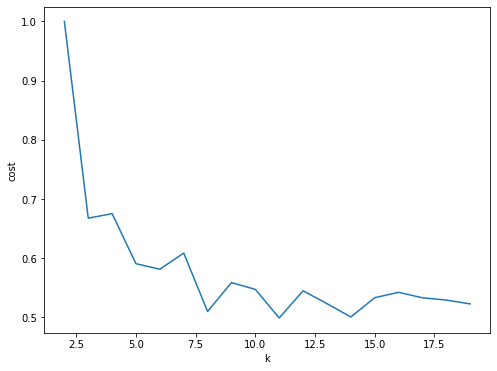

In [0]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
# Loads data.
df_8 = df_opt2.select(['IncidntNum','X','Y'])
#Prepare features
FEATURES_COL = ['X', 'Y']
for col in df_8.columns:
    if col in FEATURES_COL:
        df_8 = df_8.withColumn(col,df_8[col].cast('float'))
vecAssembler = VectorAssembler(inputCols=FEATURES_COL, outputCol="features")
df_kmeans = vecAssembler.transform(df_8).select('IncidntNum', 'features')

#Optimize choice of k
cost = np.zeros(20)
for k in range(2,20):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(df_kmeans.sample(False,0.1, seed=42))
    predictions = model.transform(df_kmeans.sample(False,0.1, seed=42))
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    cost[k] = silhouette
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,20),cost[2:20])
ax.set_xlabel('k')
ax.set_ylabel('cost')
display()

### Optional part: Time series analysis
This part is not based on Spark, and only based on Pandas Time Series package.   
Note: I am not familiar with time series model, please refer the ARIMA model introduced by other teacher.   
process:  
1.visualize time series  
2.plot ACF and find optimal parameter  
3.Train ARIMA  
4.Prediction 

Refer:   
https://zhuanlan.zhihu.com/p/35282988  
https://zhuanlan.zhihu.com/p/35128342  
https://www.statsmodels.org/dev/examples/notebooks/generated/tsa_arma_0.html  
https://www.howtoing.com/a-guide-to-time-series-forecasting-with-arima-in-python-3  
https://www.joinquant.com/post/9576?tag=algorithm  
https://blog.csdn.net/u012052268/article/details/79452244

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from pylab import rcParams

import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

from plotly import tools

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [0]:
from pyspark.sql.functions import hour, date_format, to_date, month, year
# add new columns to convert Date to date format
df_time = df_opt2.withColumn("IncidentDate",to_date(df_opt2.Date, "MM/dd/yyyy")) 
df_time = df_time.groupBy("IncidentDate").count().orderBy("IncidentDate")
display(df_time)

IncidentDate count 2003-01-01 582 2003-01-02 384 2003-01-03 418 2003-01-04 328 2003-01-05 367 2003-01-06 389 2003-01-07 399 2003-01-08 512 2003-01-09 402 2003-01-10 377 2003-01-11 351 2003-01-12 308 2003-01-13 378 2003-01-14 387 2003-01-15 397 2003-01-16 385 2003-01-17 419 2003-01-18 345 2003-01-19 291 2003-01-20 399 2003-01-21 360 2003-01-22 440 2003-01-23 434 2003-01-24 436 2003-01-25 452 2003-01-26 317 2003-01-27 403 2003-01-28 420 2003-01-29 487 2003-01-30 402 2003-01-31 397 2003-02-01 409 2003-02-02 347 2003-02-03 394 2003-02-04 435 2003-02-05 391 2003-02-06 463 2003-02-07 478 2003-02-08 354 2003-02-09 348 2003-02-10 492 2003-02-11 411 2003-02-12 396 2003-02-13 416 2003-02-14 412 2003-02-15 348 2003-02-16 315 2003-02-17 366 2003-02-18 469 2003-02-19 439 2003-02-20 410 2003-02-21 394 2003-02-22 418 2003-02-23 352 2003-02-24 387 2003-02-25 420 2003-02-26 472 2003-02-27 418 2003-02-28 423 2003-03-01 448 2003-03-02 345 2003-03-03 377 2003-03-04 450 2003-03-05 400 2003-03-06 401 2003-03-07 467 2003-03-08 399 2003-03-09 350 2003-03-10 398 2003-03-11 439 2003-03-12 497 2003-03-13 414 2003-03-14 475 2003-03-15 395 2003-03-16 349 2003-03-17 391 2003-03-18 405 2003-03-19 325 2003-03-20 438 2003-03-21 383 2003-03-22 359 2003-03-23 311 2003-03-24 361 2003-03-25 386 2003-03-26 415 2003-03-27 441 2003-03-28 426 2003-03-29 414 2003-03-30 379 2003-03-31 362 2003-04-01 505 2003-04-02 419 2003-04-03 417 2003-04-04 468 2003-04-05 399 2003-04-06 331 2003-04-07 326 2003-04-08 435 2003-04-09 464 2003-04-10 459 2003-04-11 513 2003-04-12 348 2003-04-13 376 2003-04-14 440 2003-04-15 445 2003-04-16 361 2003-04-17 394 2003-04-18 418 2003-04-19 354 2003-04-20 356 2003-04-21 356 2003-04-22 411 2003-04-23 489 2003-04-24 401 2003-04-25 414 2003-04-26 449 2003-04-27 317 2003-04-28 385 2003-04-29 405 2003-04-30 396 2003-05-01 476 2003-05-02 426 2003-05-03 325 2003-05-04 330 2003-05-05 386 2003-05-06 414 2003-05-07 392 2003-05-08 433 2003-05-09 412 2003-05-10 359 2003-05-11 319 2003-05-12 424 2003-05-13 447 2003-05-14 453 2003-05-15 428 2003-05-16 427 2003-05-17 321 2003-05-18 366 2003-05-19 371 2003-05-20 387 2003-05-21 375 2003-05-22 400 2003-05-23 391 2003-05-24 364 2003-05-25 306 2003-05-26 336 2003-05-27 432 2003-05-28 356 2003-05-29 425 2003-05-30 379 2003-05-31 381 2003-06-01 430 2003-06-02 427 2003-06-03 385 2003-06-04 423 2003-06-05 399 2003-06-06 397 2003-06-07 327 2003-06-08 362 2003-06-09 390 2003-06-10 447 2003-06-11 363 2003-06-12 417 2003-06-13 422 2003-06-14 336 2003-06-15 304 2003-06-16 369 2003-06-17 365 2003-06-18 380 2003-06-19 382 2003-06-20 435 2003-06-21 363 2003-06-22 279 2003-06-23 386 2003-06-24 394 2003-06-25 417 2003-06-26 437 2003-06-27 371 2003-06-28 365 2003-06-29 323 2003-06-30 356 2003-07-01 504 2003-07-02 401 2003-07-03 459 2003-07-04 355 2003-07-05 325 2003-07-06 337 2003-07-07 374 2003-07-08 390 2003-07-09 386 2003-07-10 379 2003-07-11 436 2003-07-12 327 2003-07-13 339 2003-07-14 349 2003-07-15 428 2003-07-16 460 2003-07-17 423 2003-07-18 407 2003-07-19 462 2003-07-20 359 2003-07-21 409 2003-07-22 377 2003-07-23 410 2003-07-24 382 2003-07-25 413 2003-07-26 345 2003-07-27 310 2003-07-28 361 2003-07-29 361 2003-07-30 309 2003-07-31 312 2003-08-01 459 2003-08-02 375 2003-08-03 350 2003-08-04 371 2003-08-05 374 2003-08-06 400 2003-08-07 446 2003-08-08 372 2003-08-09 377 2003-08-10 371 2003-08-11 401 2003-08-12 404 2003-08-13 439 2003-08-14 432 2003-08-15 454 2003-08-16 366 2003-08-17 313 2003-08-18 361 2003-08-19 409 2003-08-20 440 2003-08-21 444 2003-08-22 458 2003-08-23 386 2003-08-24 364 2003-08-25 377 2003-08-26 402 2003-08-27 435 2003-08-28 447 2003-08-29 383 2003-08-30 418 2003-08-31 362 2003-09-01 407 2003-09-02 376 2003-09-03 361 2003-09-04 353 2003-09-05 449 2003-09-06 406 2003-09-07 367 2003-09-08 370 2003-09-09 420 2003-09-10 434 2003-09-11 475 2003-09-12 431 2003-09-13 404 2003-09-14 351 2003-09-15 403 2003-09-16 422 2003-09-17 400 2003-09-18 445 2003-09-19 432 2003-09-20 396 2003-09-21 369 2003-09-22 427 2003-0

Databricks visualization. Run in Databricks to view.

IncidentDate count 2003-01-01 582 2003-01-02 384 2003-01-03 418 2003-01-04 328 2003-01-05 367 2003-01-06 389 2003-01-07 399 2003-01-08 512 2003-01-09 402 2003-01-10 377 2003-01-11 351 2003-01-12 308 2003-01-13 378 2003-01-14 387 2003-01-15 397 2003-01-16 385 2003-01-17 419 2003-01-18 345 2003-01-19 291 2003-01-20 399 2003-01-21 360 2003-01-22 440 2003-01-23 434 2003-01-24 436 2003-01-25 452 2003-01-26 317 2003-01-27 403 2003-01-28 420 2003-01-29 487 2003-01-30 402 2003-01-31 397 2003-02-01 409 2003-02-02 347 2003-02-03 394 2003-02-04 435 2003-02-05 391 2003-02-06 463 2003-02-07 478 2003-02-08 354 2003-02-09 348 2003-02-10 492 2003-02-11 411 2003-02-12 396 2003-02-13 416 2003-02-14 412 2003-02-15 348 2003-02-16 315 2003-02-17 366 2003-02-18 469 2003-02-19 439 2003-02-20 410 2003-02-21 394 2003-02-22 418 2003-02-23 352 2003-02-24 387 2003-02-25 420 2003-02-26 472 2003-02-27 418 2003-02-28 423 2003-03-01 448 2003-03-02 345 2003-03-03 377 2003-03-04 450 2003-03-05 400 2003-03-06 401 2003-03-07 467 2003-03-08 399 2003-03-09 350 2003-03-10 398 2003-03-11 439 2003-03-12 497 2003-03-13 414 2003-03-14 475 2003-03-15 395 2003-03-16 349 2003-03-17 391 2003-03-18 405 2003-03-19 325 2003-03-20 438 2003-03-21 383 2003-03-22 359 2003-03-23 311 2003-03-24 361 2003-03-25 386 2003-03-26 415 2003-03-27 441 2003-03-28 426 2003-03-29 414 2003-03-30 379 2003-03-31 362 2003-04-01 505 2003-04-02 419 2003-04-03 417 2003-04-04 468 2003-04-05 399 2003-04-06 331 2003-04-07 326 2003-04-08 435 2003-04-09 464 2003-04-10 459 2003-04-11 513 2003-04-12 348 2003-04-13 376 2003-04-14 440 2003-04-15 445 2003-04-16 361 2003-04-17 394 2003-04-18 418 2003-04-19 354 2003-04-20 356 2003-04-21 356 2003-04-22 411 2003-04-23 489 2003-04-24 401 2003-04-25 414 2003-04-26 449 2003-04-27 317 2003-04-28 385 2003-04-29 405 2003-04-30 396 2003-05-01 476 2003-05-02 426 2003-05-03 325 2003-05-04 330 2003-05-05 386 2003-05-06 414 2003-05-07 392 2003-05-08 433 2003-05-09 412 2003-05-10 359 2003-05-11 319 2003-05-12 424 2003-05-13 447 2003-05-14 453 2003-05-15 428 2003-05-16 427 2003-05-17 321 2003-05-18 366 2003-05-19 371 2003-05-20 387 2003-05-21 375 2003-05-22 400 2003-05-23 391 2003-05-24 364 2003-05-25 306 2003-05-26 336 2003-05-27 432 2003-05-28 356 2003-05-29 425 2003-05-30 379 2003-05-31 381 2003-06-01 430 2003-06-02 427 2003-06-03 385 2003-06-04 423 2003-06-05 399 2003-06-06 397 2003-06-07 327 2003-06-08 362 2003-06-09 390 2003-06-10 447 2003-06-11 363 2003-06-12 417 2003-06-13 422 2003-06-14 336 2003-06-15 304 2003-06-16 369 2003-06-17 365 2003-06-18 380 2003-06-19 382 2003-06-20 435 2003-06-21 363 2003-06-22 279 2003-06-23 386 2003-06-24 394 2003-06-25 417 2003-06-26 437 2003-06-27 371 2003-06-28 365 2003-06-29 323 2003-06-30 356 2003-07-01 504 2003-07-02 401 2003-07-03 459 2003-07-04 355 2003-07-05 325 2003-07-06 337 2003-07-07 374 2003-07-08 390 2003-07-09 386 2003-07-10 379 2003-07-11 436 2003-07-12 327 2003-07-13 339 2003-07-14 349 2003-07-15 428 2003-07-16 460 2003-07-17 423 2003-07-18 407 2003-07-19 462 2003-07-20 359 2003-07-21 409 2003-07-22 377 2003-07-23 410 2003-07-24 382 2003-07-25 413 2003-07-26 345 2003-07-27 310 2003-07-28 361 2003-07-29 361 2003-07-30 309 2003-07-31 312 2003-08-01 459 2003-08-02 375 2003-08-03 350 2003-08-04 371 2003-08-05 374 2003-08-06 400 2003-08-07 446 2003-08-08 372 2003-08-09 377 2003-08-10 371 2003-08-11 401 2003-08-12 404 2003-08-13 439 2003-08-14 432 2003-08-15 454 2003-08-16 366 2003-08-17 313 2003-08-18 361 2003-08-19 409 2003-08-20 440 2003-08-21 444 2003-08-22 458 2003-08-23 386 2003-08-24 364 2003-08-25 377 2003-08-26 402 2003-08-27 435 2003-08-28 447 2003-08-29 383 2003-08-30 418 2003-08-31 362 2003-09-01 407 2003-09-02 376 2003-09-03 361 2003-09-04 353 2003-09-05 449 2003-09-06 406 2003-09-07 367 2003-09-08 370 2003-09-09 420 2003-09-10 434 2003-09-11 475 2003-09-12 431 2003-09-13 404 2003-09-14 351 2003-09-15 403 2003-09-16 422 2003-09-17 400 2003-09-18 445 2003-09-19 432 2003-09-20 396 2003-09-21 369 2003-09-22 427 2003-0

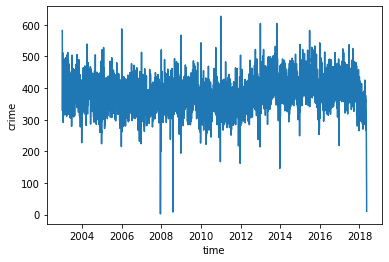

In [0]:
crime_time = df_time.toPandas()
plt.xlabel('time')
plt.ylabel('crime')
plt.plot('IncidentDate', 'count', data=crime_time)
display(crime_time)

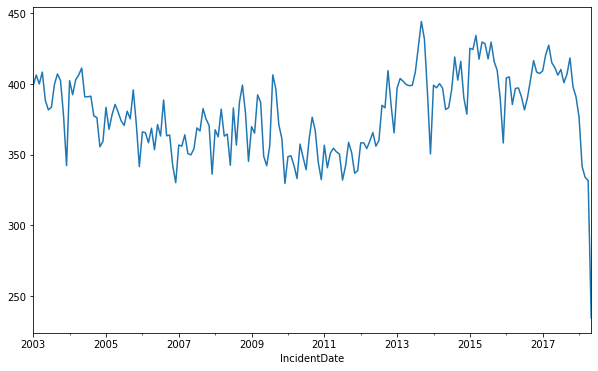

In [0]:
crime_time = crime_time.set_index(crime_time['IncidentDate'])
crime_time.index = pd.to_datetime(crime_time.index)
y = crime_time['count'].resample('MS').mean()
y.plot(figsize=(10, 6))
plt.show() # possible seasonal trends

In [0]:
display(y.describe())

count    185.000000
mean     378.980908
std       28.493487
min      234.600000
25%      358.258065
50%      380.774194
75%      400.000000
max      444.166667
Name: count, dtype: float64

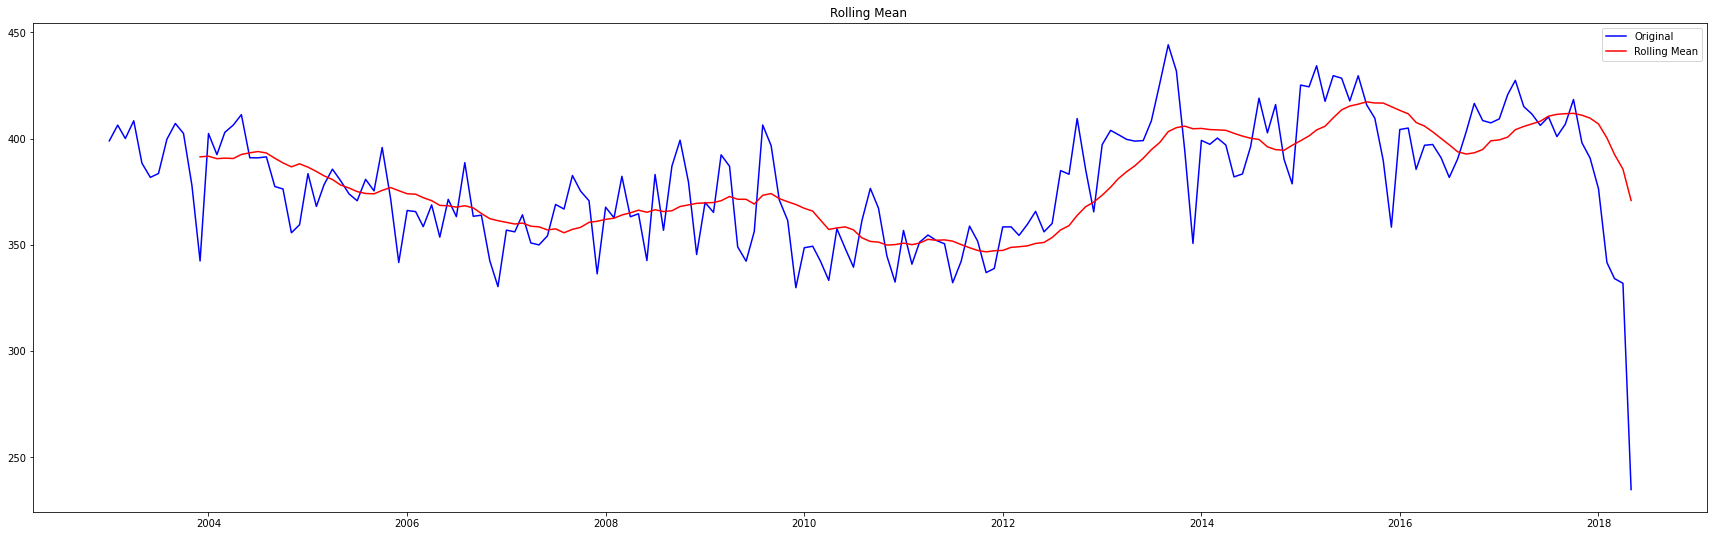

In [0]:
rollingmean = y.rolling(window=12).mean()
rollingstd = y.rolling(window=12).std()

orig = plt.plot(y, color='blue', label='Original')
mean = plt.plot(rollingmean , color='red', label='Rolling Mean')
#std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.rcParams["figure.figsize"] = (30,9)

plt.legend(loc='best')
plt.title('Rolling Mean ')
plt.show(block=False)

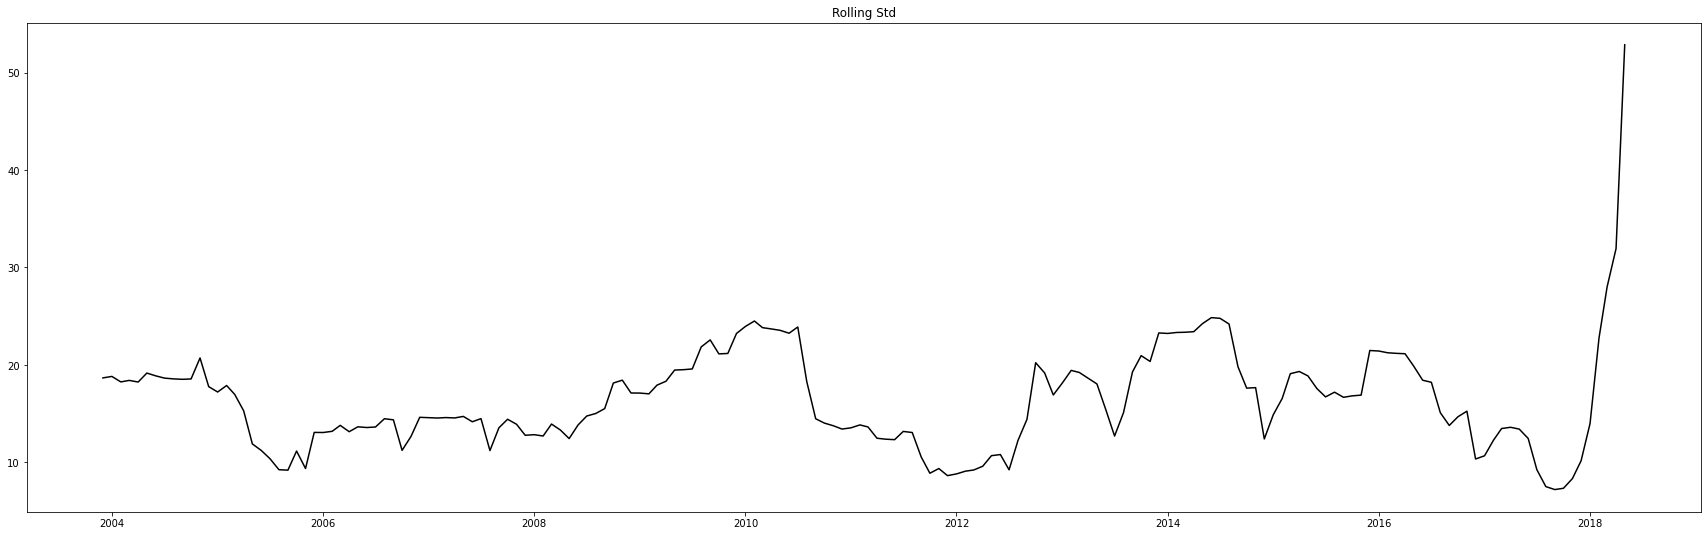

In [0]:
std = plt.plot(rollingstd, color='black', label='Rolling Std')
plt.title('Rolling Std')
plt.show(block=False)

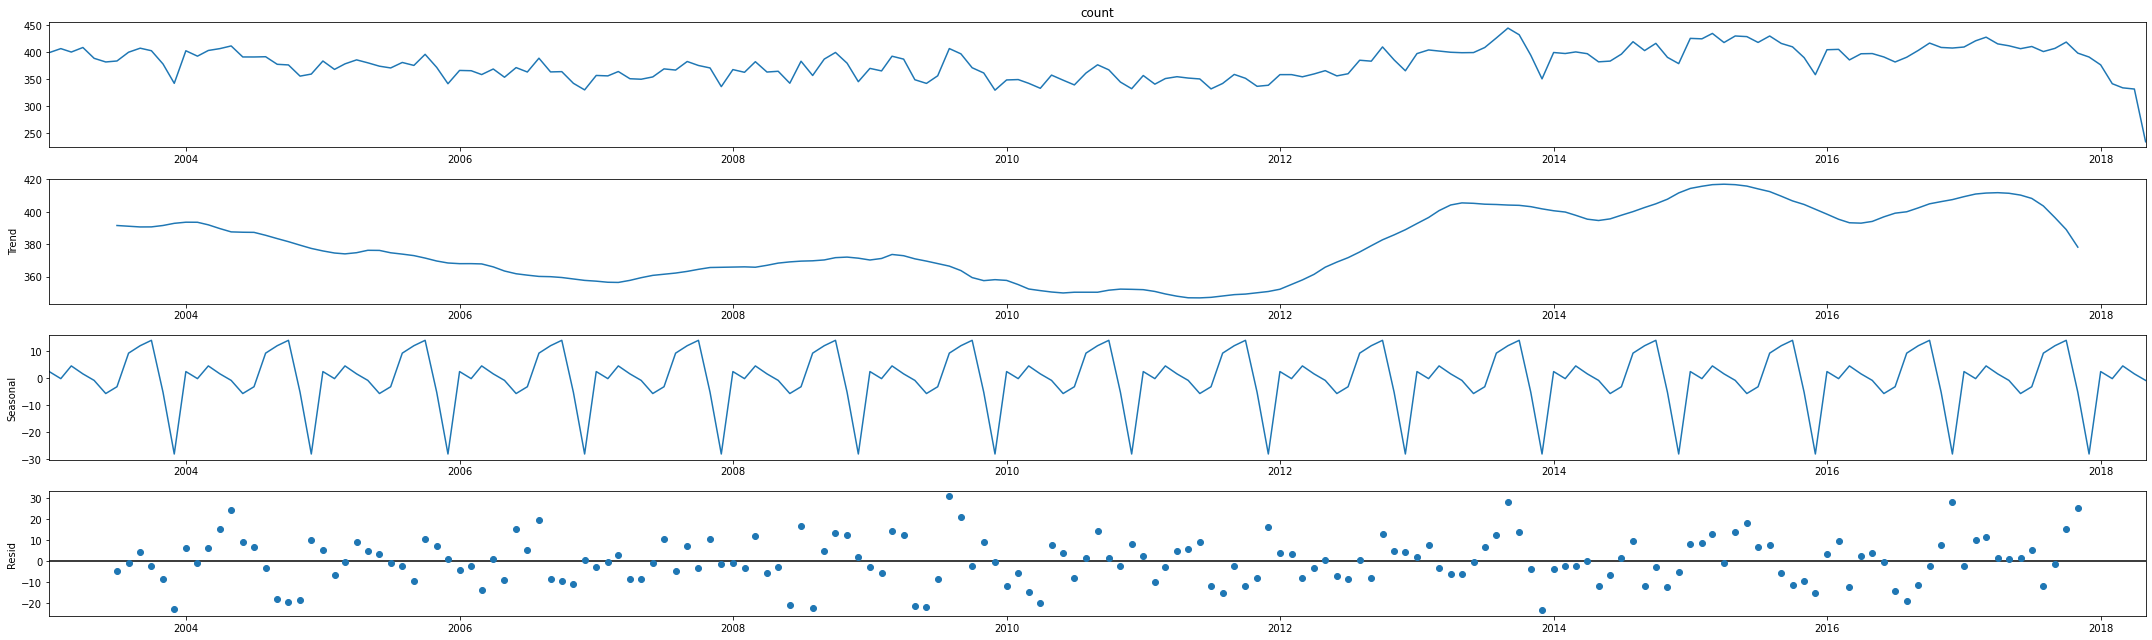

In [0]:
deco = sm.tsa.seasonal_decompose(y, model='additive')
fig = deco.plot()
plt.rcParams["figure.figsize"] = (30,10)

plt.show()

### Quite strong seasonal trend. However, the 2018 data does not seem to follow the trend very smoothly

In [0]:
deco.resid.describe()

Out[97]: count    173.000000
mean       0.241092
std       10.610351
min      -23.148302
25%       -6.594541
50%       -0.329798
75%        7.406287
max       30.732949
Name: resid, dtype: float64

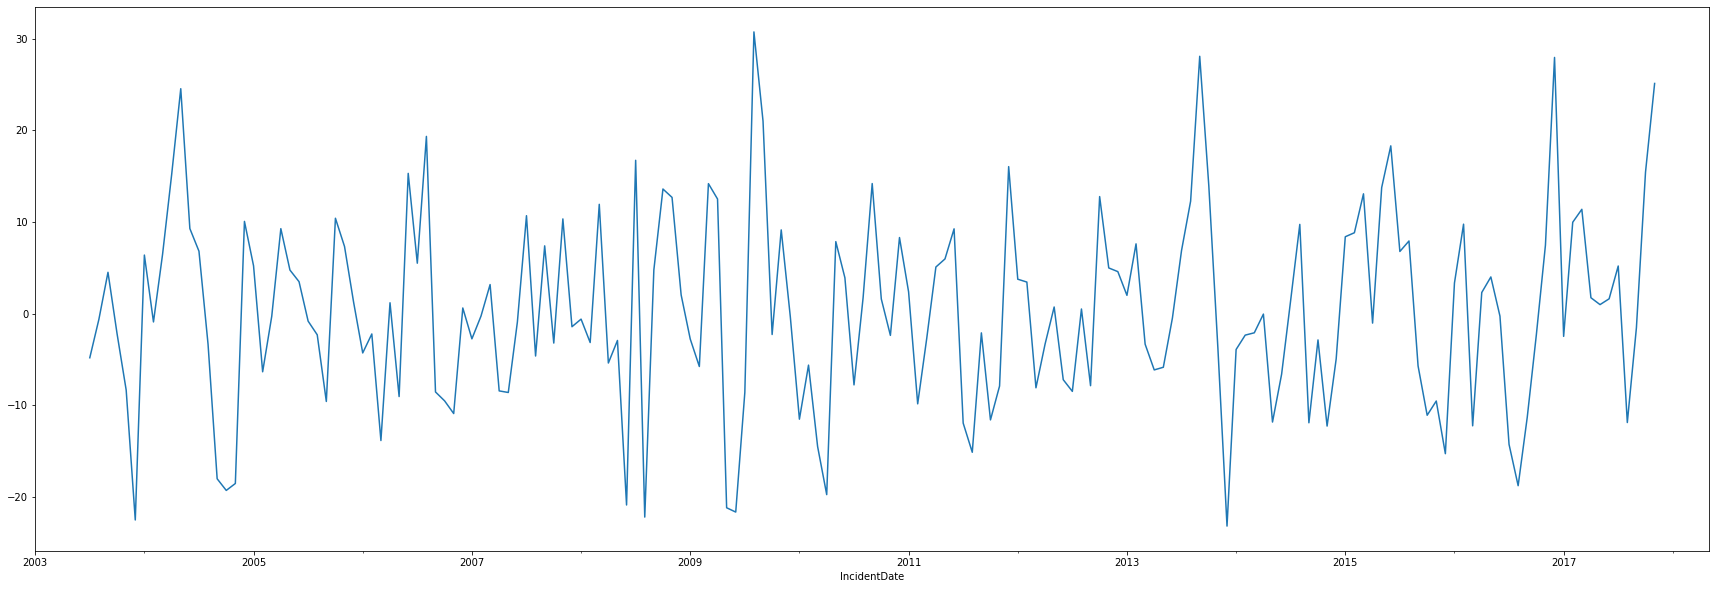

In [0]:
fig = deco.resid.plot()
plt.show()

### the residual does look randomly distributed with zero mean and equal varaince, therefore, the model makes sense

In [0]:
display(deco.resid.isnull().sum())

12

In [0]:
Residual = deco.resid
Residual = Residual.fillna(Residual.bfill())
Residual = Residual.fillna(Residual.ffill())
ADFresult = adfuller(Residual)
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.794090
p-value: 0.000000
Critical Values:
	1%: -3.466
	5%: -2.877
	10%: -2.575


### the statistica p-value of this model also seem to be significant

Out[106]: [<matplotlib.lines.Line2D at 0x7fa822ce9d00>]

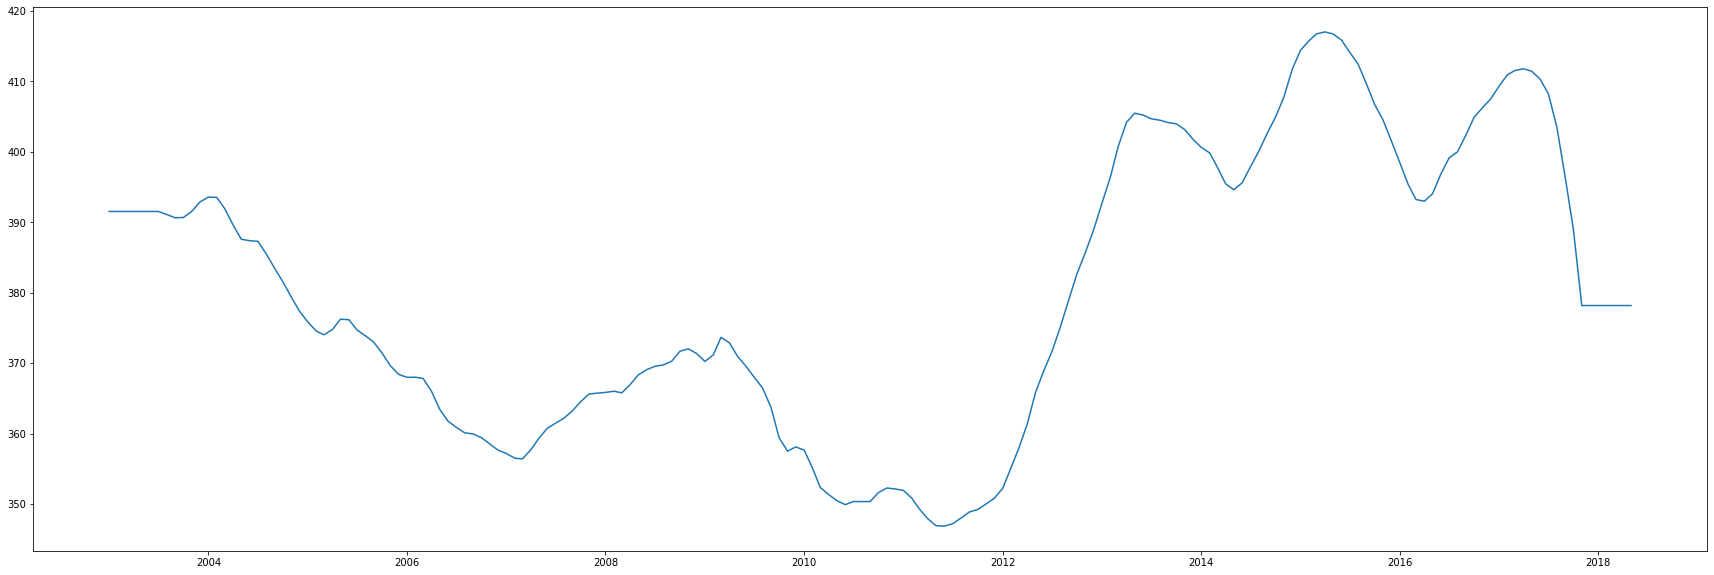

In [0]:
crimeTrend = deco.trend
crimeTrend = crimeTrend.fillna(crimeTrend.bfill())
crimeTrend = crimeTrend.fillna(crimeTrend.ffill())
plt.plot(crimeTrend , label='crime trend')

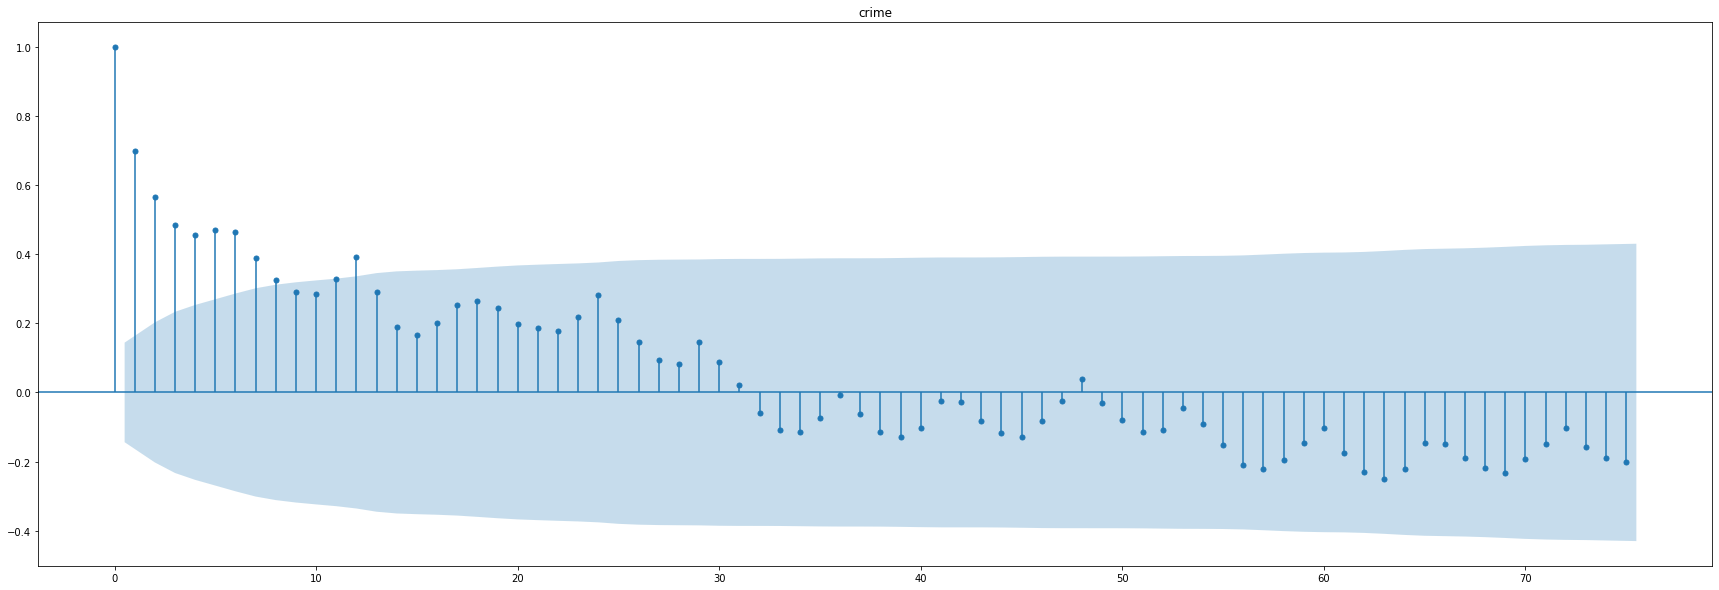

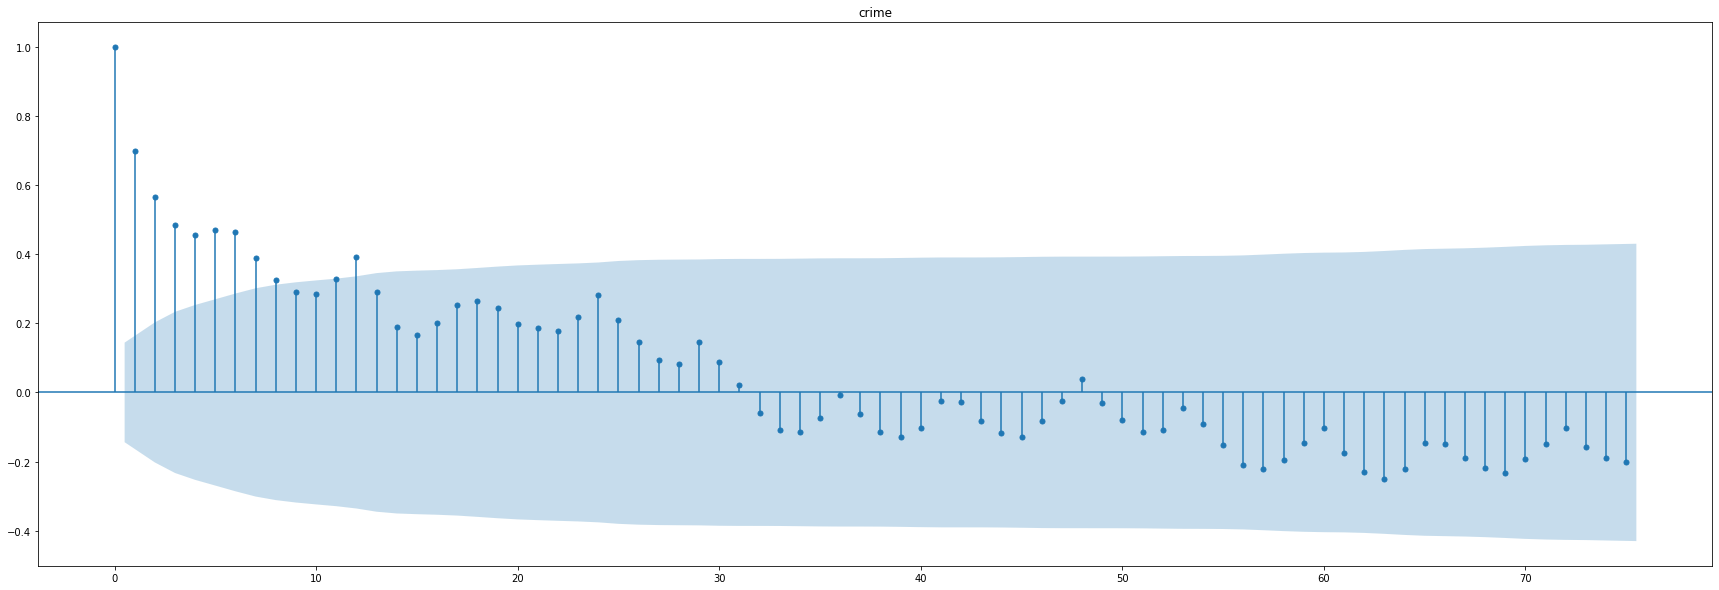

In [0]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#plot_acf(Residual,title="crime")
plot_acf(y,lags=75,title="crime")

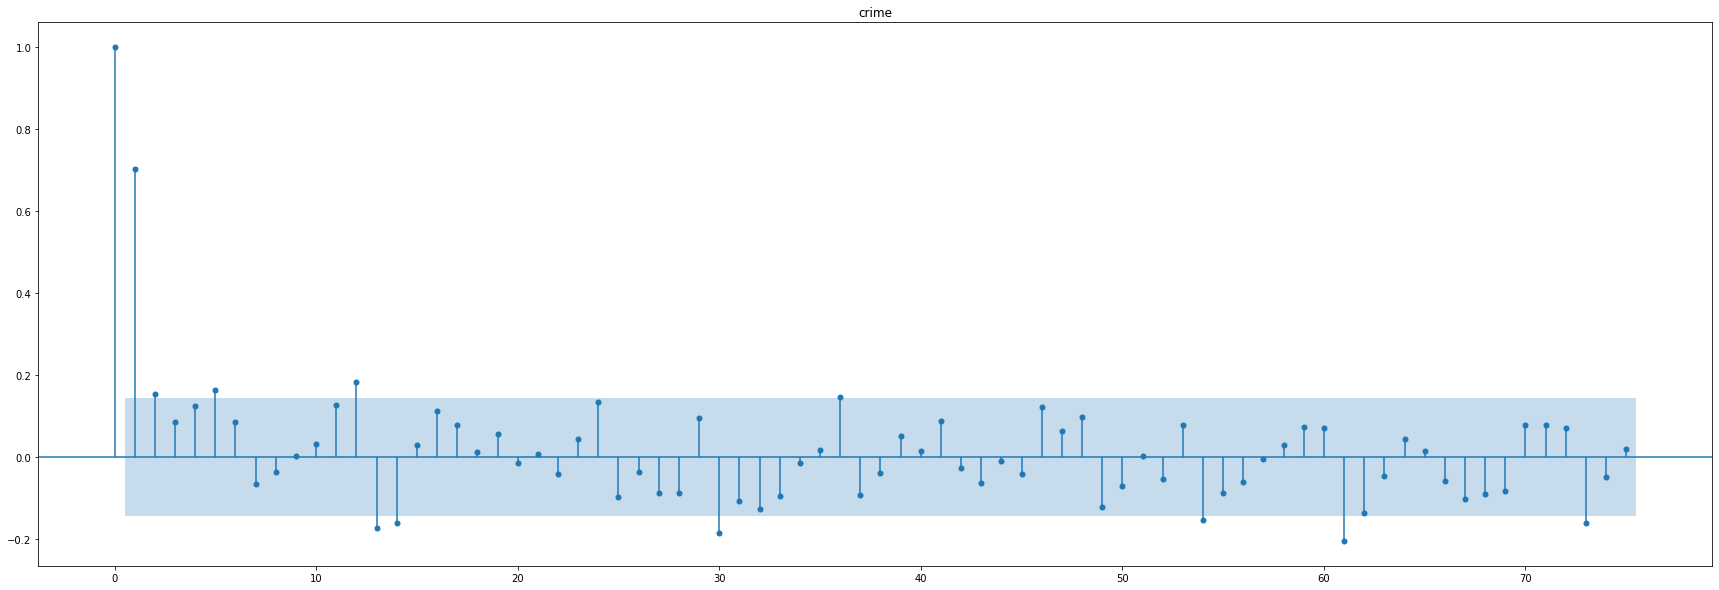

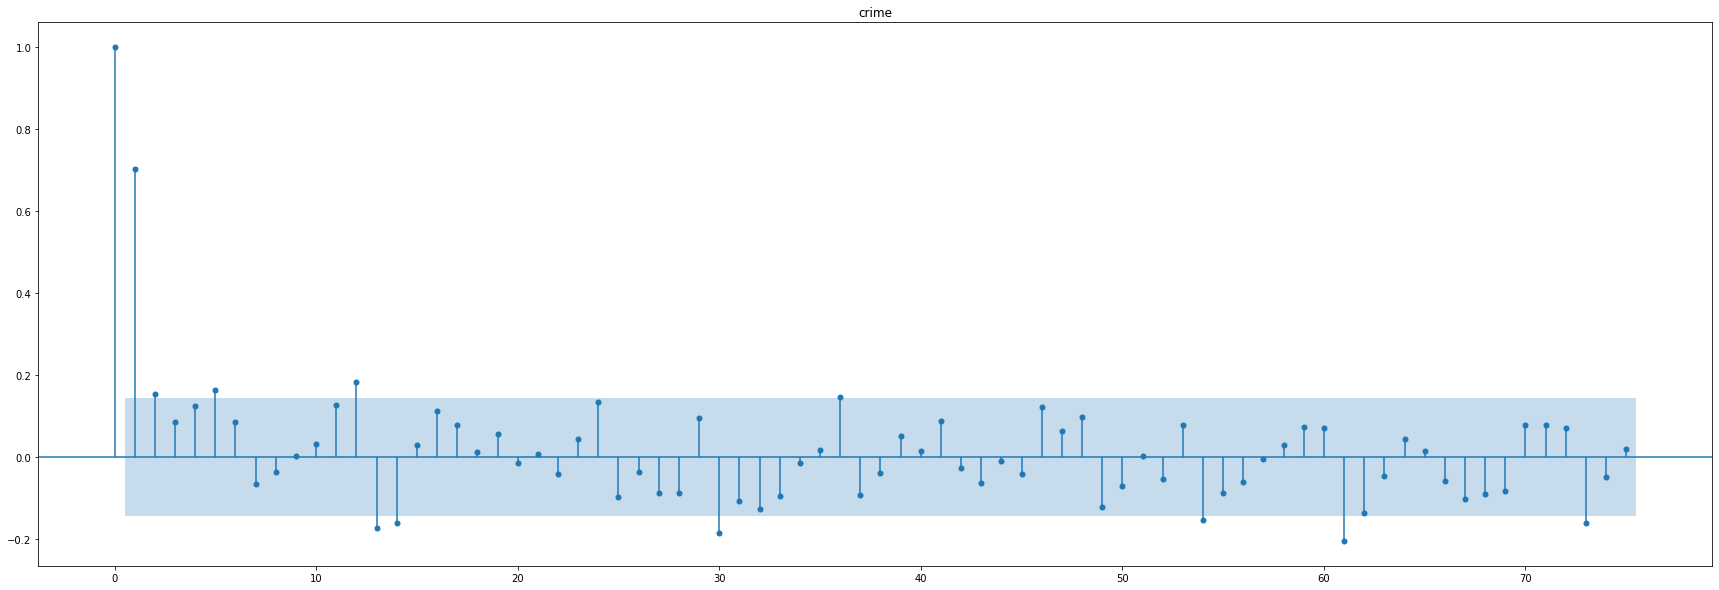

In [0]:
plot_pacf(y,lags=75,title="crime")

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/databricks/python/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.



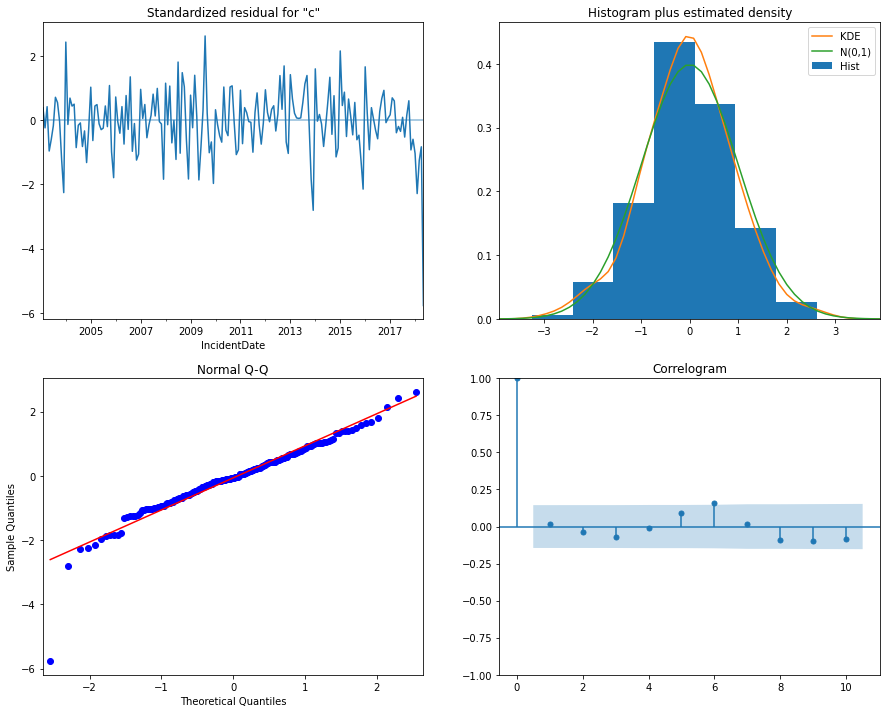

In [0]:
mod = sm.tsa.statespace.SARIMAX(y, order=(1, 1, 1))

TSresults = mod.fit()

TSresults.plot_diagnostics(figsize=(15, 12))
plt.show()

### follows the asummption of the model as shown above, perhaps excluding 1 or 2 points

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



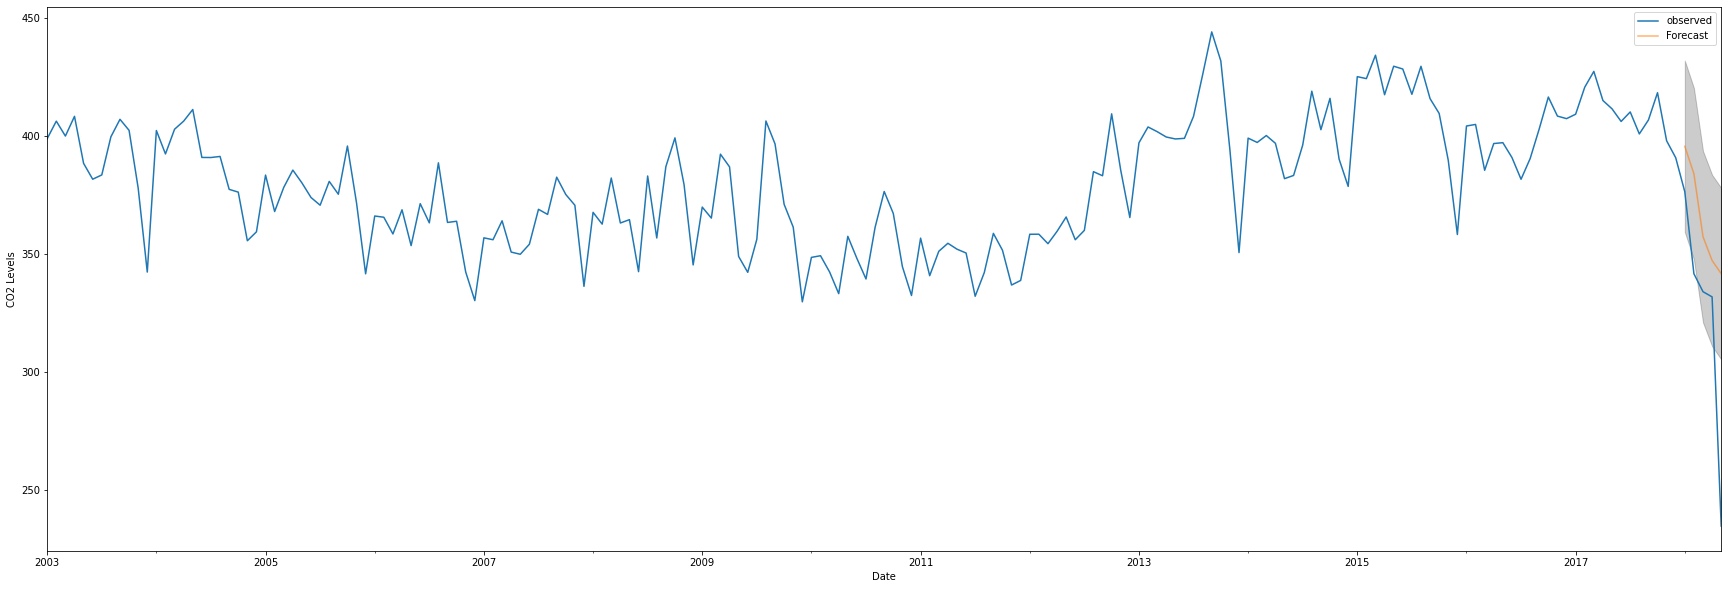

In [0]:
pred = TSresults.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
#Returns the confidence interval of the fitted parameters. 

ax = y['1990':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)

ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')
plt.legend()

plt.show()

In [0]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))


The Mean Squared Error of our forecasts is 2883.52


### prediction on the 2018 data using all of the data from 2003 to 2018 (included) still shows a bad prediction for 2018 as above. Perhasp 2018 data should be removed for better analysis and prediction

/databricks/python/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning:

The 'freq' argument in Timestamp is deprecated and will be removed in a future version.



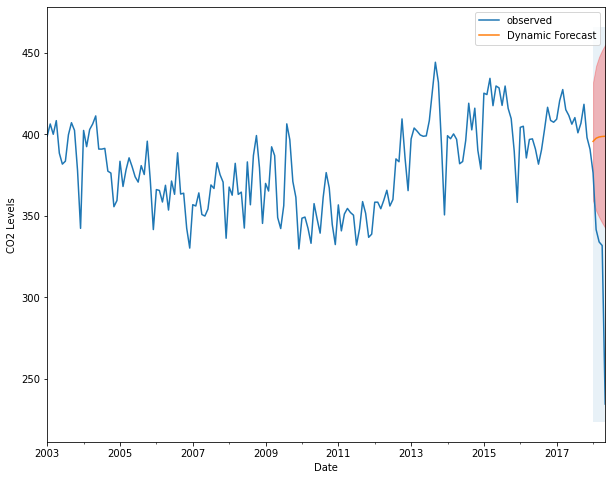

In [0]:
pred_dynamic = TSresults.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


ax = y['1990':].plot(label='observed', figsize=(10, 8))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)
ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='r', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2018-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()


Better training/model can use data from up to 2016 to predict 2017